# Analisis de series de tiempo

En este analisis crearemos una rutina para la descripcion, descomposicion y analisiz a profundidad de las series de tiempo de la red mpomm alojadas en la base de datos oficial.


## EVC-SOMO
---

### 1. Solicitud a la API **EVC-SOMO**

    Por medio de la **API-REST** creada para el manejo de los datos de la **RED MPOMM**, se ejecuta la solicitud de obtencion de la serei temporal de esta manera obtenemos los datos **oficiales** avalados por el area de **SOMO** del centro de investigaciones del pacifico.

In [50]:
# Solicitud de datos a la API REST
from api_somo import APIClient, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2009-01-01",
    "end_date":"2023-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie,  red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)
    red_mpomm_serie.index = red_mpomm_serie.index.strftime('%Y-%m-%d %H:%M')


    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie.columns)
display(round(red_mpomm_serie.describe(),3))
red_mpomm_serie

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.
ERROR:__main__:Error fetching historical series: 'Index' object has no attribute 'strftime'


Index(['value', 'qf'], dtype='object')

,value,qf
count,731807.000,731807.000
mean,-4052.049,1.324
std,19717.745,1.578
min,-99999.000,1.000
25%,0.000,1.000
50%,0.000,1.000
75%,0.000,1.000
max,1464.000,9.000


,value,qf
timestamp,,
2009-02-01 05:10:00,0.0,1
2009-02-01 05:20:00,0.0,1
2009-02-01 05:30:00,0.0,1
2009-02-01 05:40:00,0.0,1
2009-02-01 05:50:00,0.0,1
...,...,...
2023-01-01 04:10:00,0.0,1
2023-01-01 04:20:00,0.0,1
2023-01-01 04:30:00,0.0,1


### 2. Preprocesamiento de los datos

Manejo de datos con baja calidad

Ya que la serie tiene una previa evaluacion de calidad, manejamos solo los datos que se consideran "buenos", convertimos a **NaN** los valores asociados a calidades distintas de *bueno(1)*.
- Realizamos un reporte de la cantidad de NaN en la serie
- Se extraen los valores del sensor y se convierten en una **serie** de pandas 
- Verificamos sus estadisticas.

In [99]:
import numpy as np
import pandas as pd

red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index).tz_localize(None)
#red_mpomm_serie = red_mpomm_serie.rename(columns={'value': 'tumaco'})

red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
#red_mpomm_serie.drop(columns=['latitude','longitude'], inplace=True)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
print('Reporte de datos NaN por columna: ')
display(red_mpomm_serie.isnull().sum())

serie = pd.Series(red_mpomm_serie.iloc[:, 0])  # Selecciona la primera columna
print('Reporte de estadistica de la serie temporal (value): ')
display(round(serie.describe(),3))

Reporte de datos NaN por columna: 


value    29717
qf       29717
dtype: int64

Reporte de estadistica de la serie temporal (value): 


count    702090.000
mean          0.049
std           0.503
min           0.000
25%           0.000
50%           0.000
75%           0.000
max          57.200
Name: value, dtype: float64

### 3. Remuestreo de la serie.

En este punto se toman los valores del sensor en la variable **serie**, se aplica un remuestreo de la serie ya que la maxima resolucion que nos da chirps es diaria entonces debemos submuestrear esta serie para obtener una diaria, pero en la rutina vamos a incluir un umbral de calidad con el cual controlaremos hasta que porcentaje de nans podemos aceptar para tomar como valido el dato remuestreado.

    El porcentaje maximo permitido para este caso lo dejamos en 20%


In [52]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
serie = serie.resample('3h').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN y/o null en la serie actual: ')
print(serie.isnull().sum(),'\n')


Reporte de datos NaN y/o null en la serie actual: 
1845 



Hasta este punto tenemos nuestra serie temporal de la redMPOMM preprocesada y en formato serie de pandas, con el nombre **serie** como variable para usar en posteriores procesos.

3. Grafica temporal de la serie

En esta podemos ver la grafica temporal de la serie con esta tenemos una idea general del comportamiento de la variable que estamos explorando.


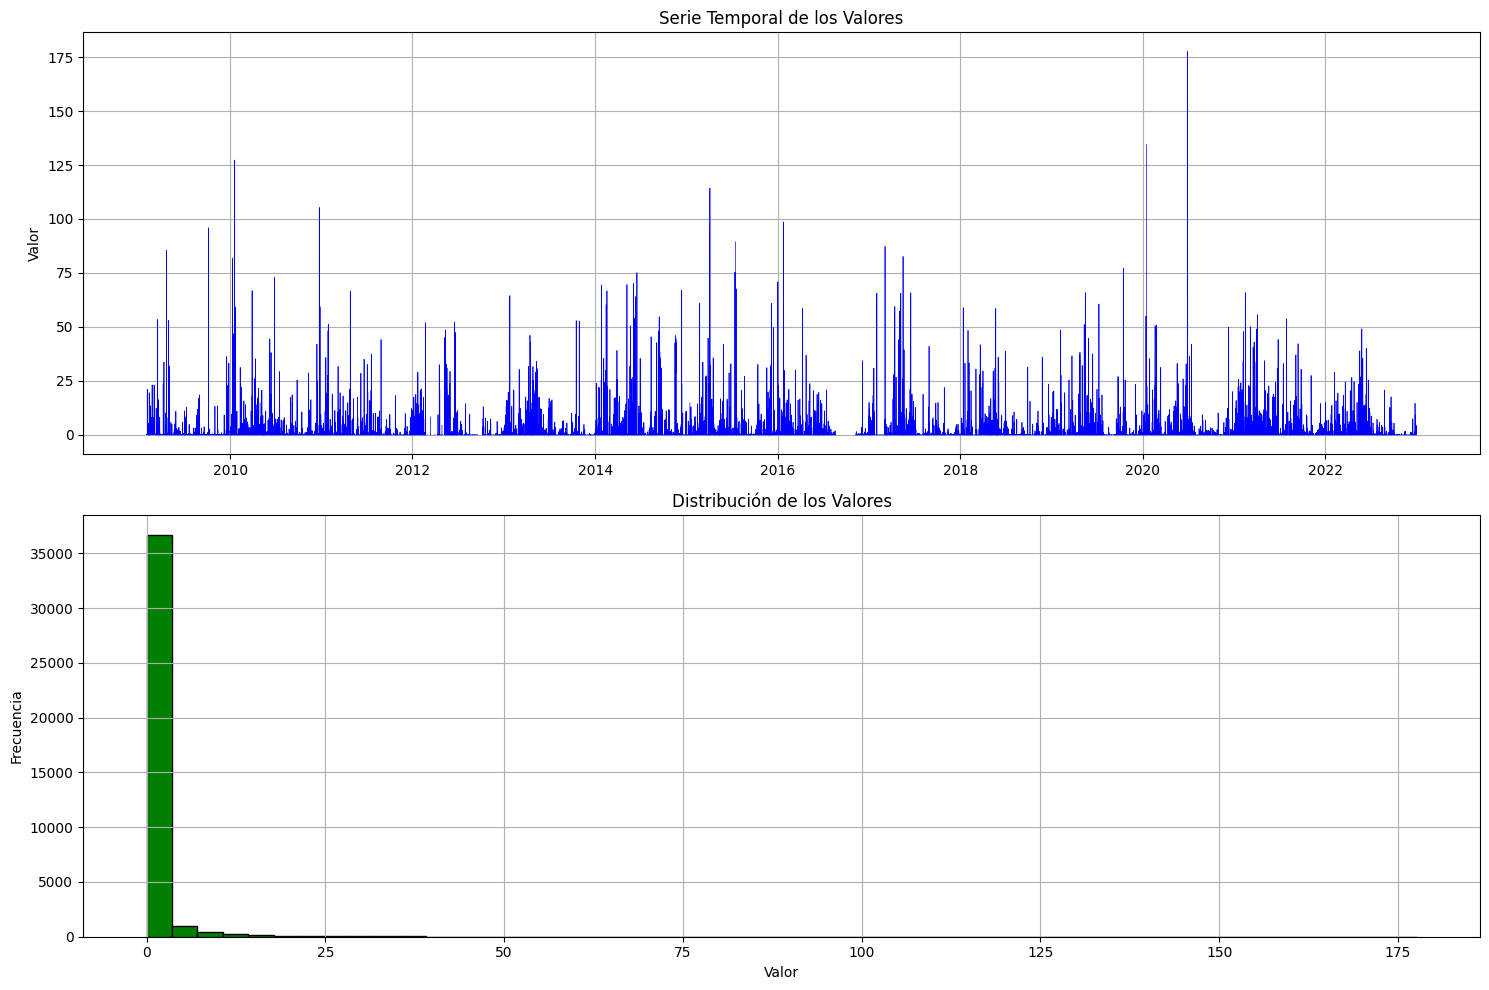

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

# Gráfico temporal
axes[0].plot(serie, color='blue', linewidth=0.5)
axes[0].set_title('Serie Temporal de los Valores')
axes[0].set_ylabel('Valor')
axes[0].grid(True)

# Histograma de distribución
axes[1].hist(serie, bins=50, color='green', edgecolor='black')
axes[1].set_title('Distribución de los Valores')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True)

# Ajustar y mostrar
plt.tight_layout()
plt.show()


### CHIRPS

- Consulta a la base de datos
    Al igual que la etapa anterior, con los datos recolectados de la base de datos de chirp que luego se alojaron en el datalake y luego fueron procesados transformados y carrgados (etl), a la base de datos de mongo, relaizaremos las consultas para poder obtener los datos y su preprocesamieto.

In [54]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['tumaco']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        data_mongo_df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in data_mongo_df.columns:
            data_mongo_df = data_mongo_df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        data_mongo_df = data_mongo_df[data_mongo_df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        display(data_mongo_df.head(5))

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


,point_id,latitude,longitude,value,timestamp
5,point_6,1.774998,-78.725006,0.000000,2009-02-01
9,point_10,1.824997,-78.725006,0.000000,2009-02-01
11,point_12,1.824997,-78.775000,0.000000,2009-02-01
17,point_6,1.774998,-78.725006,0.000000,2009-02-02
21,point_10,1.824997,-78.725006,12.457714,2009-02-02


Se obtiene la informacion de la base de datos en mongo, ahora se procede a realizar el proceso de transformacion de los datos, para poder trabajar junto a la serie de la red mpomm.

2. Preprocesamiento de los datos
    
- obtencion de datos
    
    Se deben crear series temporales de cada punto geografico.

In [55]:
import pandas as pd

# Suponiendo que df es tu dataset original
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
series_chirps = data_mongo_df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(series_chirps.head(5))


point_id,point_10,point_12,point_6
timestamp,,,
2009-02-01,0.000000,0.000000,0.000000
2009-02-02,12.457714,16.109703,0.000000
2009-02-03,12.457714,16.109703,29.260645
2009-02-04,0.000000,0.000000,0.000000
2009-02-05,0.000000,0.000000,0.000000


Se obtiene un dataframe **series_chirps** con las series temporales de cada punto geografico seleccionado.

- Filtrado
    
    Ahora podemos realizar el proceso de **filtrado** de control de calidad como manejo de nan o de outlyers

In [56]:
# Convertir el índice de series_chirps a naive (sin zona horaria)
series_chirps.index = series_chirps.index.tz_localize(None)
# Reemplazar los valores mayores a 500 por NaN
series_chirps = series_chirps.mask(series_chirps > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
series_chirps.isnull().sum()

point_id
point_10    1
point_12    0
point_6     6
dtype: int64

Se imponen condiciones o reglas de filtrado para limpiar la señal

## Dataset
---

Como parte final de este proceso se realiza la union de los datos a trabajar en un solo dataframe para mayor facilidad en la manipulacion de los mismos.

In [57]:

# Crear el dataset vacío
dataset = pd.DataFrame()

# Convertir índice a datetime sin zona horaria (si es necesario)
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Unir las series
dataset = serie.to_frame().join(series_chirps, how="inner").copy(deep=True)
#dataset['timestamp_format'] = dataset.index.strftime('%Y-%m-%d')

# Bloquear escritura para hacerlo inmutable
dataset.flags.writeable = False

# Mostrar información
print(dataset.shape)
display(dataset.head())


(5082, 4)


,value,point_10,point_12,point_6
timestamp,,,,
2009-02-02,0.1,12.457714,16.109703,0.000000
2009-02-03,0.0,12.457714,16.109703,29.260645
2009-02-04,0.0,0.000000,0.000000,0.000000
2009-02-05,0.0,0.000000,0.000000,0.000000
2009-02-06,0.0,0.000000,0.000000,0.000000


- ### Ubicacion geografica de los datos 

In [58]:
# Extraer las ubicaciones únicas
from sre_compile import dis

locations_df = data_mongo_df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Convertir red_mpomm_serie[0] en un DataFrame (si no lo es)
new_locations = pd.DataFrame([{
    'latitude': red_mpomm_metadata.get('latitude'),
    'longitude': red_mpomm_metadata.get('longitude')
}])
new_locations = new_locations.dropna()

locations_df = pd.concat([locations_df, new_locations]).drop_duplicates().reset_index(drop=True)
#correcion temporal de la location nan
#new_locations=new_locations.dropna()

# Concatenar ambos DataFrames y eliminar duplicados
locations_df = pd.concat([locations_df, new_locations]).drop_duplicates().reset_index(drop=True)

# Mostrar el resultado
print(locations_df)


import folium

# Crear el mapa centrado en la ubicación promedio
map_center = [locations_df['latitude'].mean(), locations_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Agregar marcadores al mapa
for _, row in locations_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                popup=f"Lat: {row['latitude']}, Lon: {row['longitude']}").add_to(m)

# Mostrar el mapa (en un entorno compatible como Jupyter Notebook)
m


   latitude  longitude
0  1.774998 -78.725006
1  1.824997 -78.725006
2  1.824997 -78.775000
3  1.820110 -78.728710


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

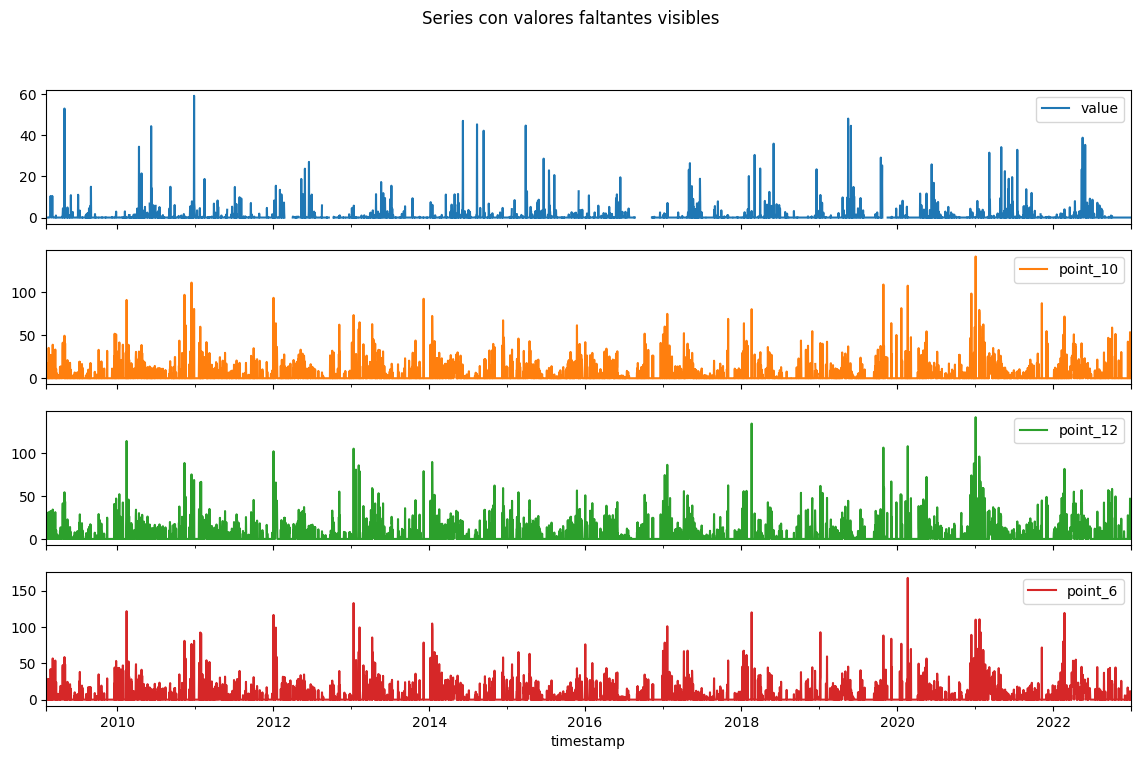

In [59]:
dataset.plot(subplots=True, figsize=(14, 8), title='Series con valores faltantes visibles')

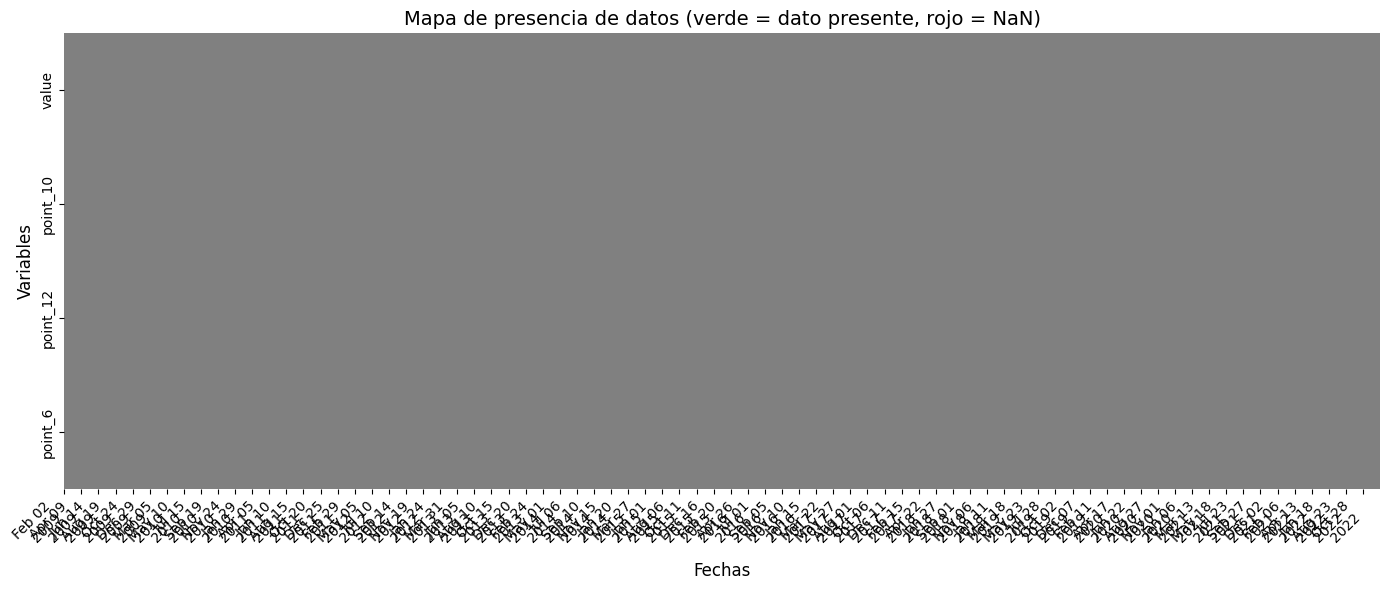

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter, AutoDateLocator


# Crear un mapa binario: 1 para datos presentes, 0 para NaN
binary_map = dataset.notna().astype(int)

# Configurar el estilo de Seaborn
#sns.set(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 6))

# Dibujar el mapa de calor
ax = sns.heatmap(
    binary_map.T,
    cmap=sns.color_palette(["#e74c3c", "#2ecc71"]),  # Rojo para NaN, verde para datos presentes
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

# Formatear las fechas en el eje X
ax.set_title("Mapa de presencia de datos (verde = dato presente, rojo = NaN)", fontsize=14)
ax.set_xlabel("Fechas", fontsize=12)
ax.set_ylabel("Variables", fontsize=12)

# Obtener y ajustar las etiquetas del eje X (que representa las fechas)
ax.set_xticks(ax.get_xticks())  # Forzar actualización de ticks
ax.set_xticklabels(
    [pd.to_datetime(label.get_text()).strftime('%b %d\n%Y') for label in ax.get_xticklabels()],
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()


<Axes: ylabel='timestamp'>

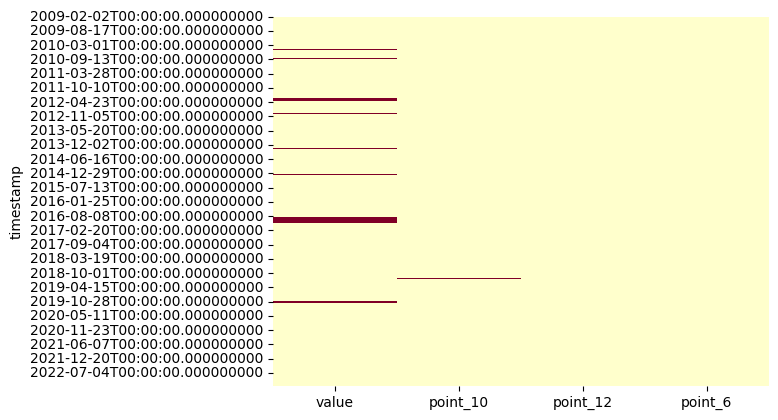

In [61]:
import seaborn as sns
sns.heatmap(dataset.isnull(), cbar=False, cmap='YlOrRd')


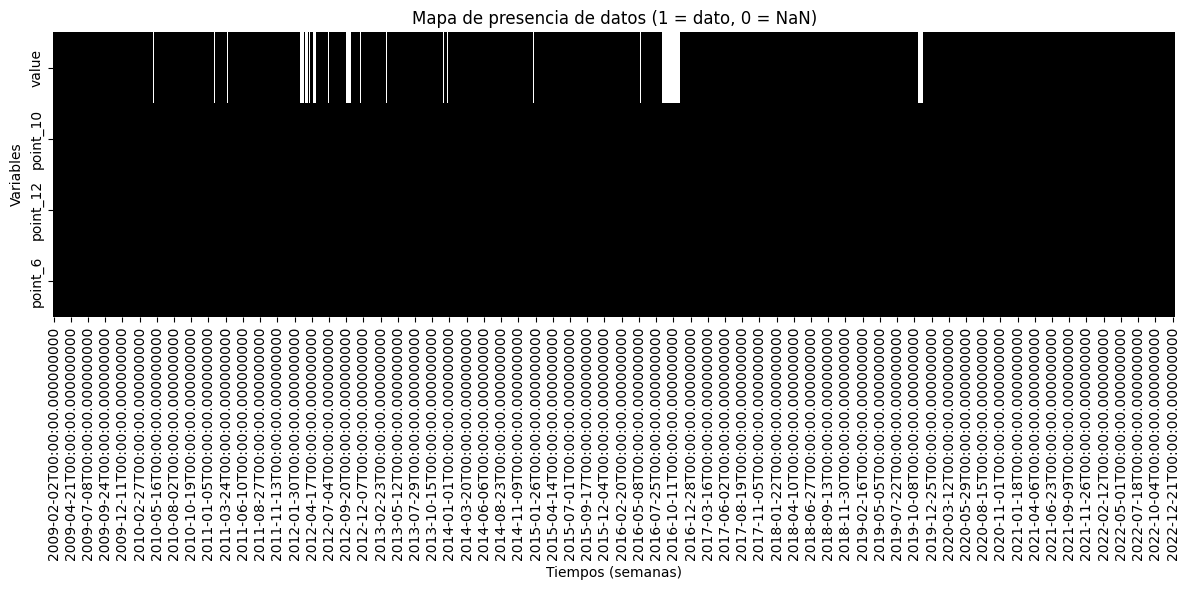

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un mapa binario: 1 para datos buenos, 0 para NaN
binary_map = dataset.notna().astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(binary_map.T, cmap="Greys", cbar=False)

plt.title("Mapa de presencia de datos (1 = dato, 0 = NaN)")
plt.xlabel("Tiempos (semanas)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


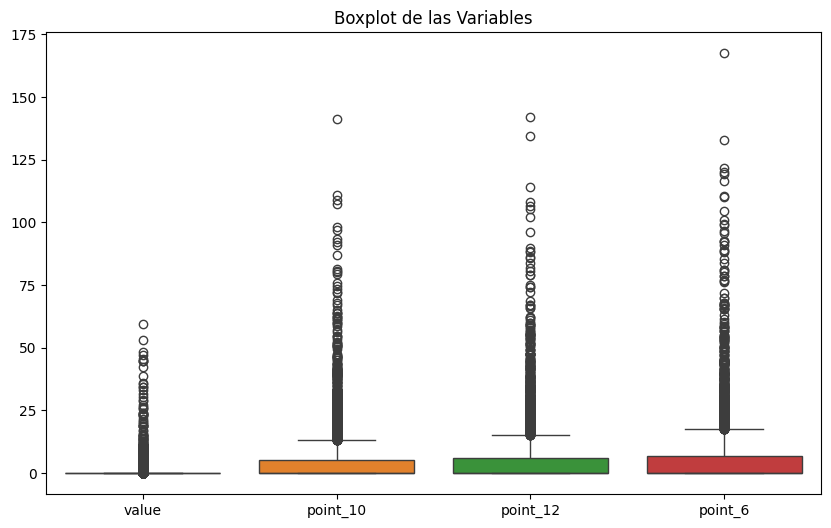

In [63]:
# Crear boxplots para cada columna
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset[['value', 'point_10', 'point_12', 'point_6']])
plt.title('Boxplot de las Variables')
plt.show()

### Preprocesamiento al dataset

Se tealizan distintas transformaciones al dataset con el fin de realizar preprocesamiento estadistico para adecuar las series a los modelos antes de pasar los daots para el entrenamiento 

In [64]:
print('Reporte de datos NaN por columna antes de remuestreo: ')
print(dataset.isnull().sum(),'\n')
# Remuestrear el dataset con datos
dataset_resample = dataset.resample('W').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN por columna despues del remuestreo: ')
print(dataset_resample.isnull().sum(),'\n')
# Mostrar el DataFrame con las nuevas columnas de categorización
display(dataset_resample.head(5))

Reporte de datos NaN por columna antes de remuestreo: 
value       227
point_10      1
point_12      0
point_6       6
dtype: int64 

Reporte de datos NaN por columna despues del remuestreo: 
value       40
point_10     0
point_12     0
point_6      1
dtype: int64 



,value,point_10,point_12,point_6
timestamp,,,,
2009-02-08,0.1,24.915428,32.219406,29.260645
2009-02-15,0.0,52.841744,61.491870,69.810162
2009-02-22,1.3,20.093560,24.705463,27.666150
2009-03-01,11.6,41.724288,43.373040,64.214617
2009-03-08,11.7,38.885902,34.230297,56.642445


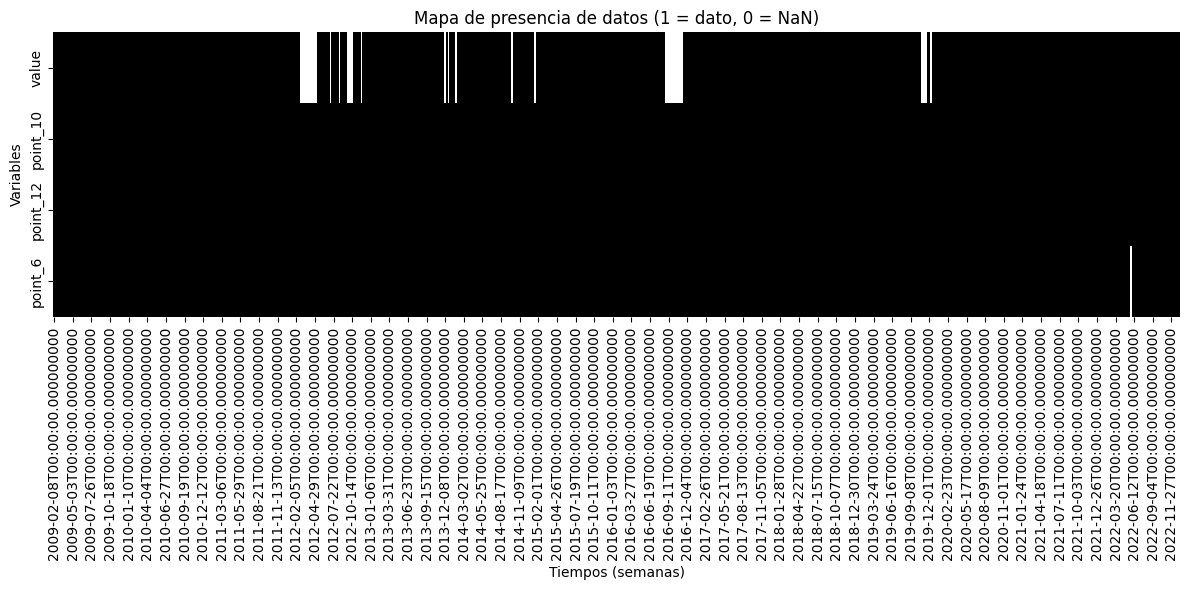

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un mapa binario: 1 para datos buenos, 0 para NaN
binary_map_resample = dataset_resample.notna().astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(binary_map_resample.T, cmap="Greys", cbar=False)

plt.title("Mapa de presencia de datos (1 = dato, 0 = NaN)")
plt.xlabel("Tiempos (semanas)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


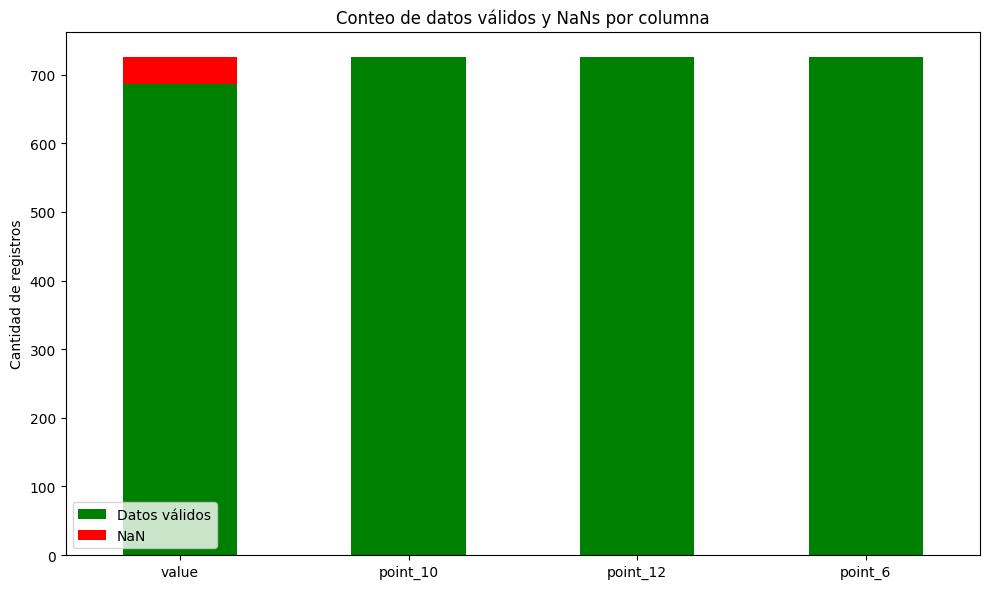

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular datos buenos y NaNs por columna
valid_counts = dataset_resample.notna().sum()
nan_counts = dataset_resample.isna().sum()

# Crear DataFrame para apilado
summary_df = pd.DataFrame({
    'Datos válidos': valid_counts,
    'NaN': nan_counts
})

# Gráfico de barras apiladas
summary_df.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6))

plt.title("Conteo de datos válidos y NaNs por columna")
plt.ylabel("Cantidad de registros")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Axes: ylabel='timestamp'>

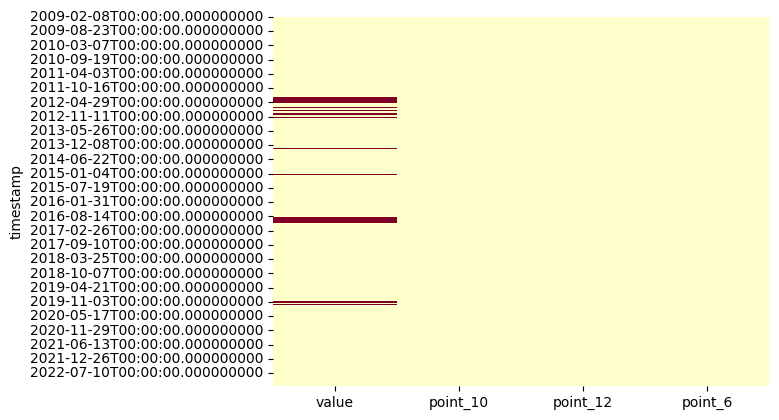

In [67]:
import seaborn as sns
sns.heatmap(dataset_resample.isnull(), cbar=False, cmap='YlOrRd')

- distribucion de los datos 

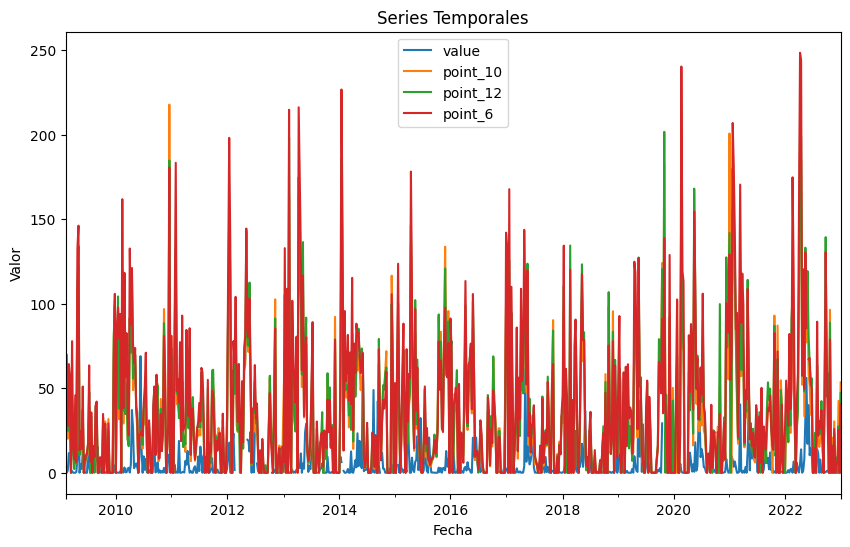

In [68]:
import matplotlib.pyplot as plt

# Graficar todas las columnas
dataset_resample[['value', 'point_10', 'point_12', 'point_6']].plot(figsize=(10, 6))
plt.title('Series Temporales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


In [69]:
"""from statsmodels.tsa.seasonal import seasonal_decompose
dataset['value'] = dataset['value'].fillna(dataset['value'].mode())  # Filling with mean
result = seasonal_decompose(dataset['value'], model='additive', period=144)
result.plot()

"""

"from statsmodels.tsa.seasonal import seasonal_decompose\ndataset['value'] = dataset['value'].fillna(dataset['value'].mode())  # Filling with mean\nresult = seasonal_decompose(dataset['value'], model='additive', period=144)\nresult.plot()\n\n"

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

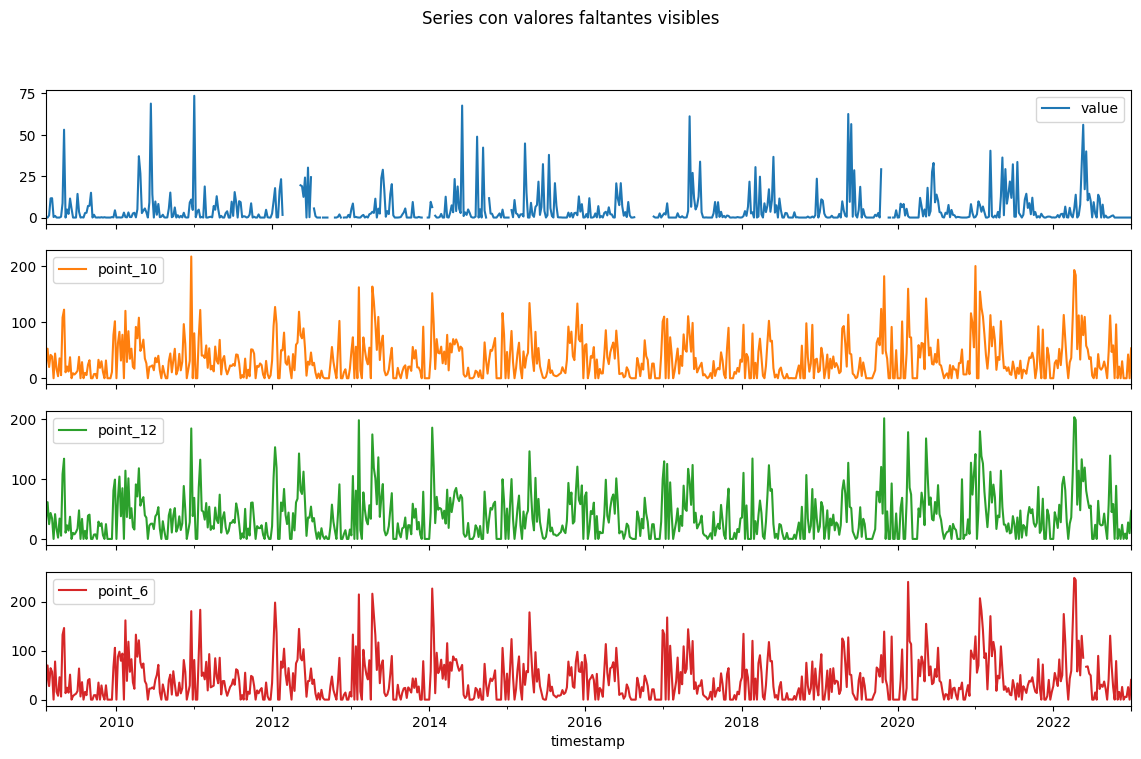

In [70]:
dataset_resample.plot(subplots=True, figsize=(14, 8), title='Series con valores faltantes visibles')

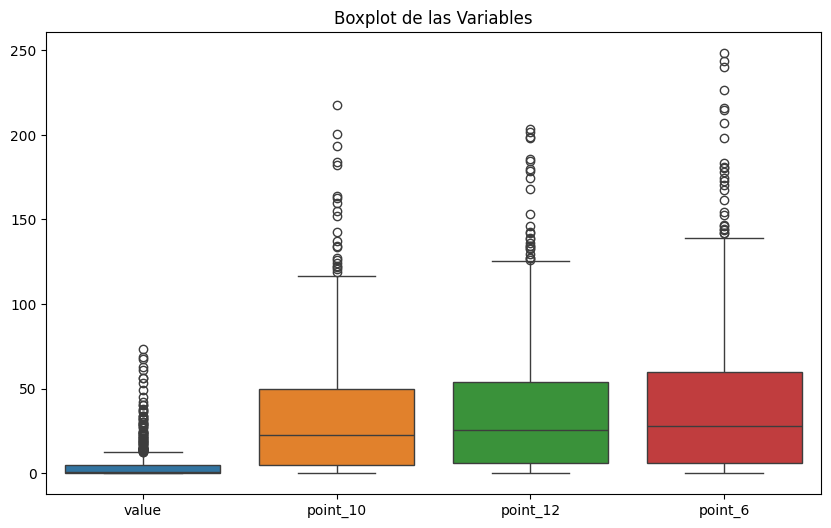

In [71]:
# Crear boxplots para cada columna
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset_resample)
plt.title('Boxplot de las Variables')
plt.show()

In [72]:
# Reemplazar valores mayores a 150 con NaN
dataset_resample_filter_level = dataset_resample.mask(dataset_resample > 200)
# Promediar col1, col2 y col3 fila por fila y guardar en nueva columna
#dataset_resample_filter_level['promedio'] = dataset_resample_filter_level[['point_10', 'point_12', 'point_6']].mean(axis=1)
print(dataset_resample_filter_level)

            value   point_10   point_12    point_6
timestamp                                         
2009-02-08    0.1  24.915428  32.219406  29.260645
2009-02-15    0.0  52.841744  61.491870  69.810162
2009-02-22    1.3  20.093560  24.705463  27.666150
2009-03-01   11.6  41.724288  43.373040  64.214617
2009-03-08   11.7  38.885902  34.230297  56.642445
...           ...        ...        ...        ...
2022-12-04    0.0   0.000000   8.987353   5.891699
2022-12-11    0.0   0.000000   0.000000   5.398974
2022-12-18    0.0  42.456190  27.553991  25.479274
2022-12-25    0.0   0.000000   9.625893   0.000000
2023-01-01    0.0  53.470882  46.993813  40.315782

[726 rows x 4 columns]


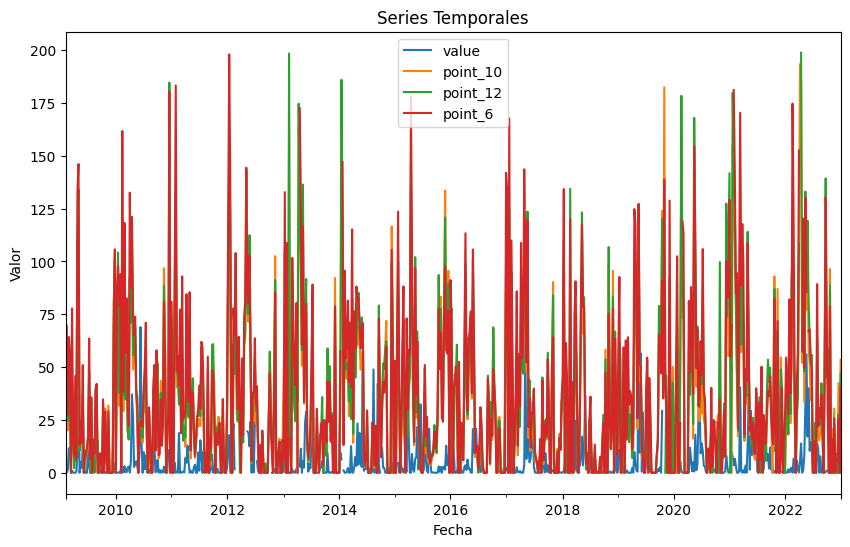

In [73]:
import matplotlib.pyplot as plt

# Graficar todas las columnas
dataset_resample_filter_level.plot(figsize=(10, 6))
plt.title('Series Temporales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


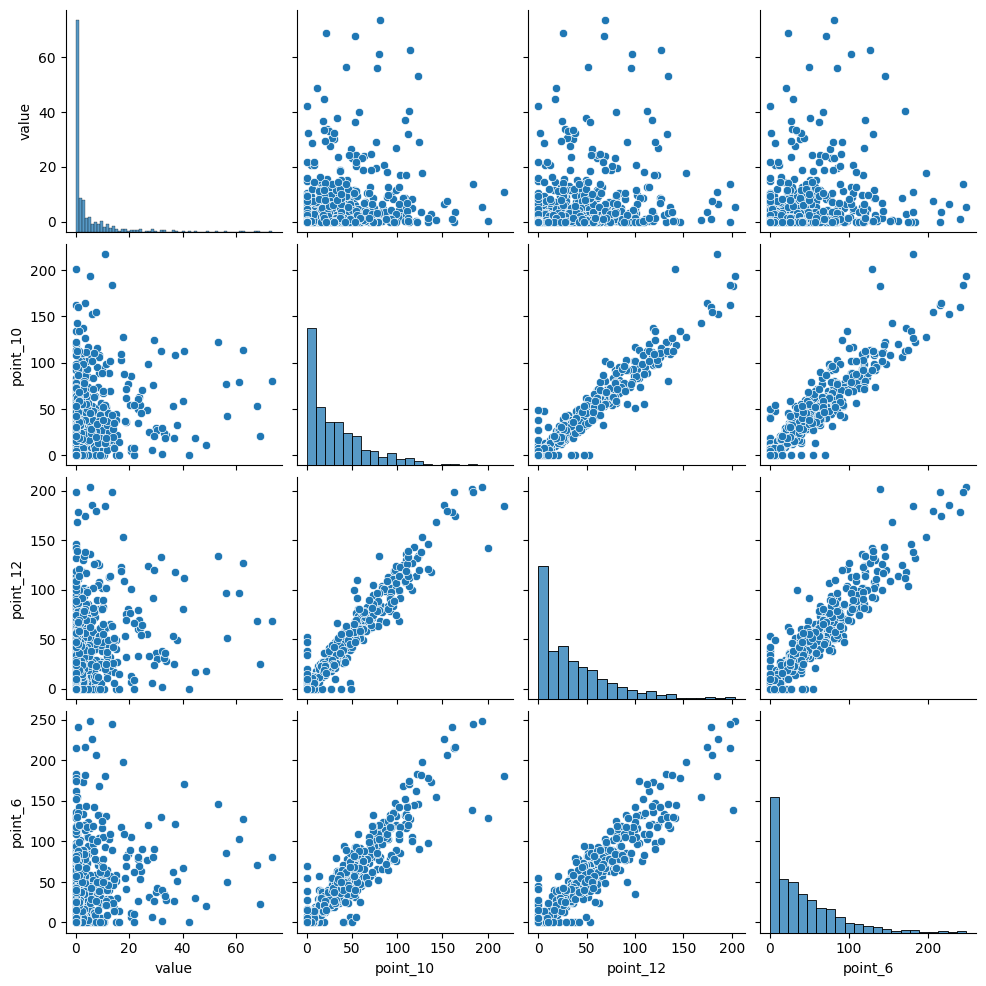

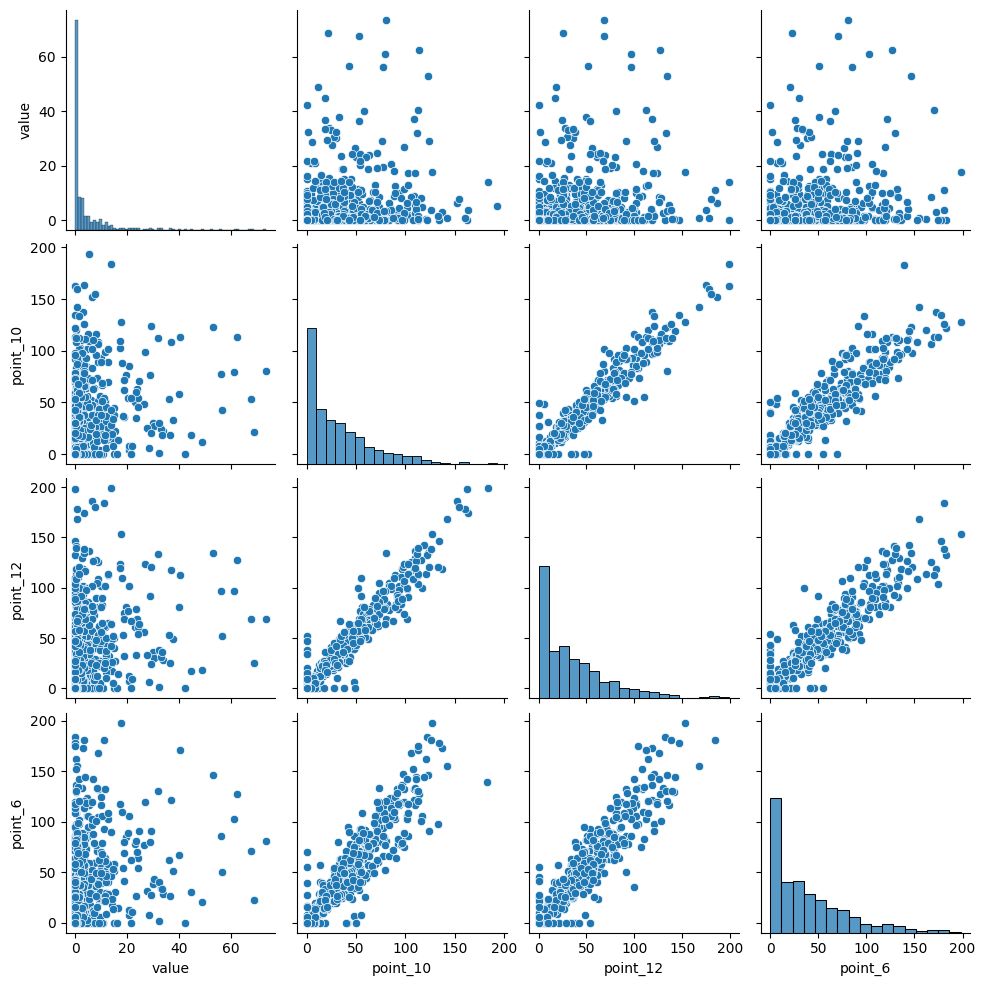

In [74]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(dataset_resample)
sns.pairplot(dataset_resample_filter_level)
# Metodo numerico
#dataset.corr()

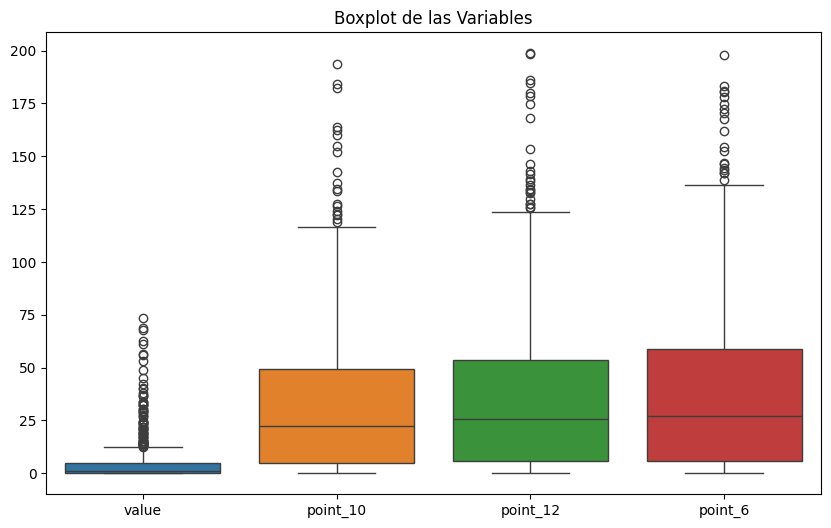

In [75]:
# Crear boxplots para cada columna
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset_resample_filter_level)
plt.title('Boxplot de las Variables')
plt.show()

<Axes: >

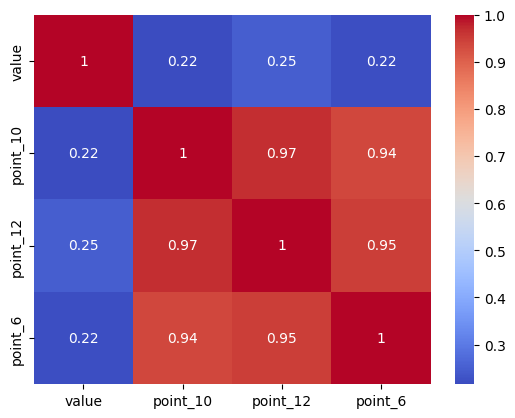

In [76]:
import seaborn as sns
sns.heatmap(dataset_resample.corr(), annot=True, cmap='coolwarm')


<Axes: >

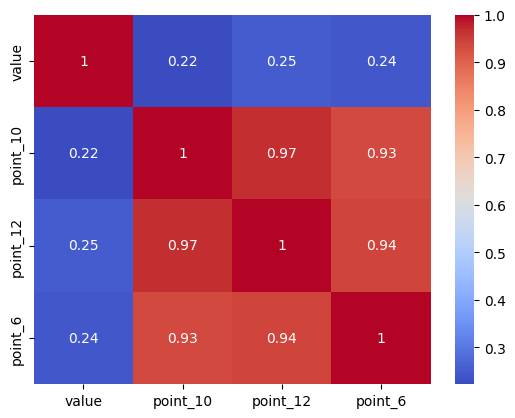

In [77]:

sns.heatmap(dataset_resample_filter_level.corr(), annot=True, cmap='coolwarm')

<Axes: title={'center': 'Cantidad de datos presentes por variable'}>

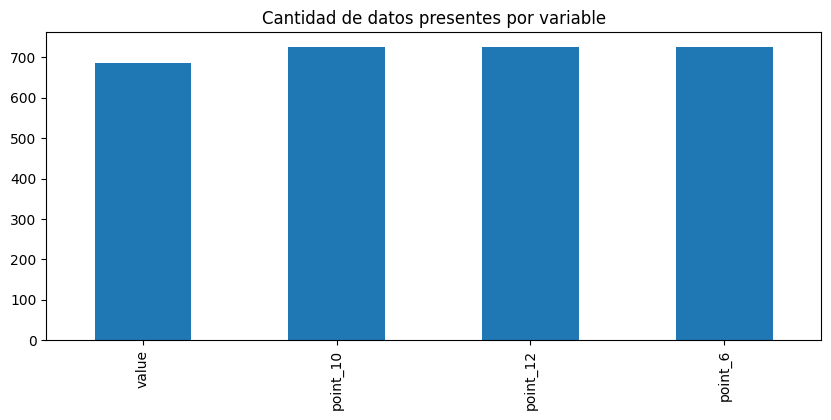

In [78]:
dataset_resample.notnull().sum().plot(kind='bar', figsize=(10, 4), title='Cantidad de datos presentes por variable')

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'point_10'}>],
       [<Axes: title={'center': 'point_12'}>,
        <Axes: title={'center': 'point_6'}>]], dtype=object)

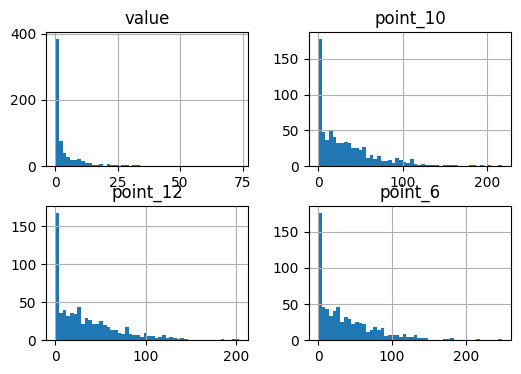

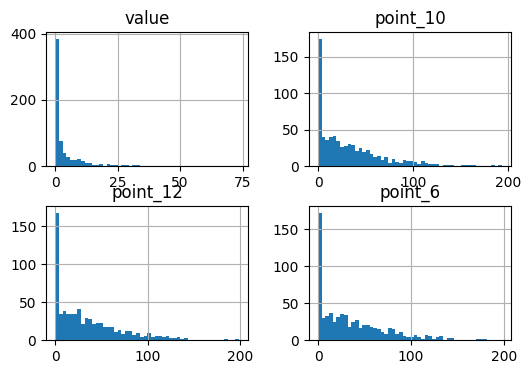

In [79]:
dataset_resample.hist(bins=50, figsize=(6, 4))
dataset_resample_filter_level.hist(bins=50, figsize=(6, 4))

<Axes: title={'center': 'Intervalos entre registros'}, xlabel='timestamp'>

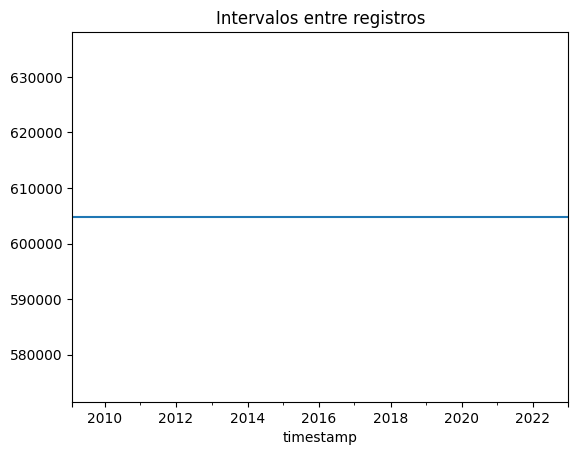

In [80]:
diffs = dataset_resample.index.to_series().diff().dt.total_seconds()
diffs.plot(title='Intervalos entre registros')

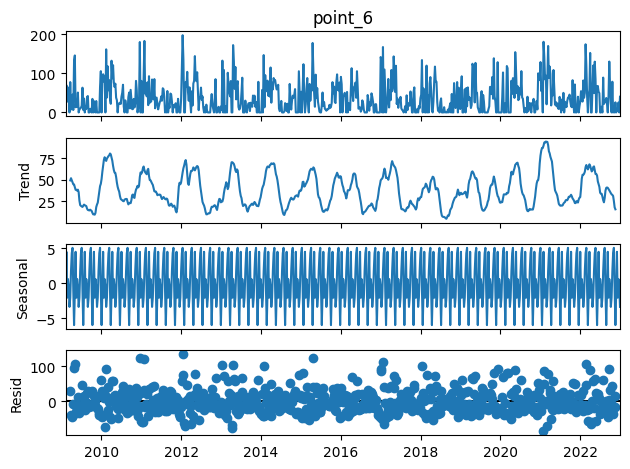

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Rellenar NaN con la moda más frecuente
dataset_resample_filter_level['point_6'] = dataset_resample_filter_level['point_6'].fillna(dataset_resample_filter_level['point_6'].mode().iloc[0])
#dataset_resample['value'] = dataset_resample['value'].fillna(dataset_resample['value'].mean())  # Filling with mean
result = seasonal_decompose(dataset_resample_filter_level['point_6'], model='additive', period=12)
result.plot()
plt.show()

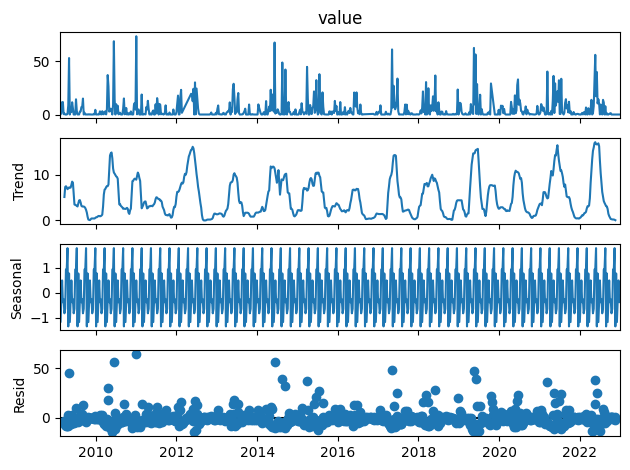

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Rellenar NaN con la moda más frecuente
#dataset_resample_filter_level['value'] = dataset_resample_filter_level['value'].fillna(dataset_resample_filter_level['value'].mode().iloc[0])
#dataset_resample['value'] = dataset_resample['value'].fillna(dataset_resample['value'].mean())  # Filling with mean#dataset_resample_filter_level['value'] = dataset_resample_filter_level['value'].interpolate(method='spline', order=4)
# Rellenar con el último valor válido
#dataset_resample_filter_level['value'] = dataset_resample_filter_level['value'].fillna(method='ffill')

dataset_resample_filter_level['value'] = dataset_resample_filter_level['value'].interpolate(method='time')
result = seasonal_decompose(dataset_resample_filter_level['value'], model='additive', period=12)
result.plot()
plt.show()

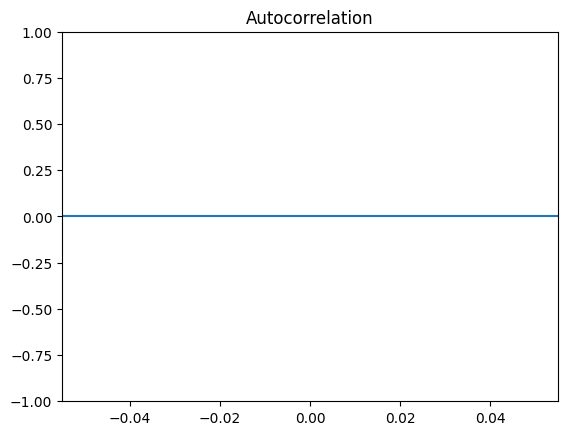

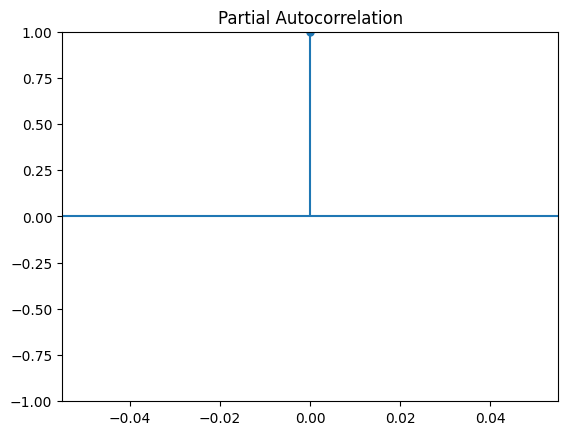

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF para la serie 'value'
plot_acf(dataset_resample['value'], lags=12)
plt.show()

plot_pacf(dataset_resample['value'], lags=12)
plt.show()


C:\Users\dreng\AppData\Local\Temp\ipykernel_28340\2187704722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['cluster'] = kmeans.fit_predict(scaled_data)


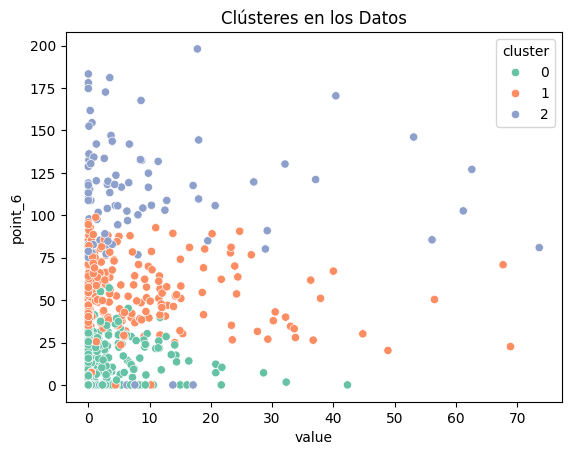

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Eliminar filas con NaN
dataset_cleaned = dataset_resample_filter_level.dropna()

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset_cleaned)

# Aplicar K-means con 3 clusters
kmeans = KMeans(n_clusters=3)
dataset_cleaned['cluster'] = kmeans.fit_predict(scaled_data)

# Graficar los clústeres
sns.scatterplot(x=dataset_cleaned['value'], y=dataset_cleaned['point_6'], hue=dataset_cleaned['cluster'], palette='Set2')
plt.title('Clústeres en los Datos')
plt.show()


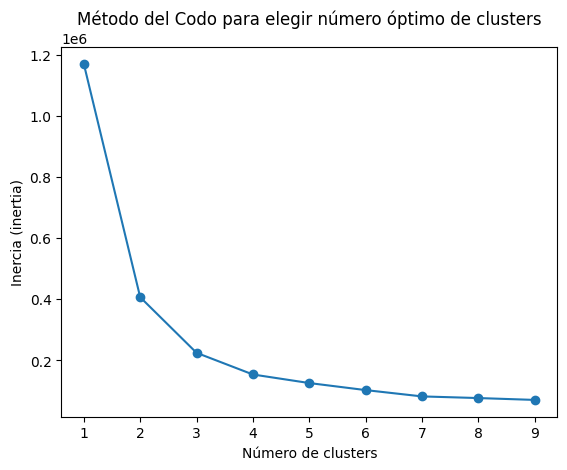

In [85]:
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset_cleaned[['value', 'point_6']])
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (inertia)')
plt.title('Método del Codo para elegir número óptimo de clusters')
plt.show()


C:\Users\dreng\AppData\Local\Temp\ipykernel_28340\1036738670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['cluster'] = kmeans.fit_predict(dataset_cleaned[['value', 'point_6']])


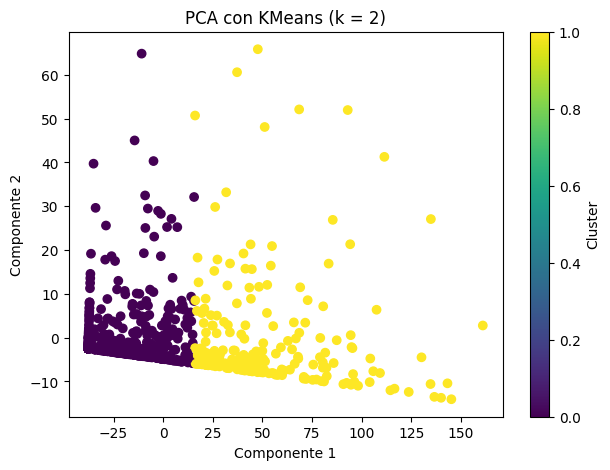

In [86]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Reentrenar KMeans con el número óptimo
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
dataset_cleaned['cluster'] = kmeans.fit_predict(dataset_cleaned[['value', 'point_6']])

#  PCA y graficar
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset_cleaned[['value', 'point_6']])

plt.figure(figsize=(7, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dataset_cleaned['cluster'], cmap='viridis')
plt.title(f'PCA con KMeans (k = {optimal_k})')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()


In [87]:
# Hacer una copia para trabajar
dataset_full = dataset_resample_filter_level.copy()

# Crear máscara para filas sin NaN en las columnas usadas en PCA
valid_mask = dataset_full[['value', 'point_6']].notna().all(axis=1)
print(valid_mask)

# Predecir clusters solo donde no hay NaN
dataset_full.loc[valid_mask, 'cluster'] = kmeans.predict(dataset_full.loc[valid_mask, ['value', 'point_6']])


timestamp
2009-02-08    True
2009-02-15    True
2009-02-22    True
2009-03-01    True
2009-03-08    True
              ... 
2022-12-04    True
2022-12-11    True
2022-12-18    True
2022-12-25    True
2023-01-01    True
Freq: W-SUN, Length: 726, dtype: bool


In [88]:
for cluster_id in dataset_full['cluster'].dropna().unique():
    cluster_mask = dataset_full['cluster'] == cluster_id
    dataset_full.loc[cluster_mask, 'value'] = dataset_full.loc[cluster_mask, 'value'].interpolate(method='linear')

dataset_interpolated = dataset_full.copy()


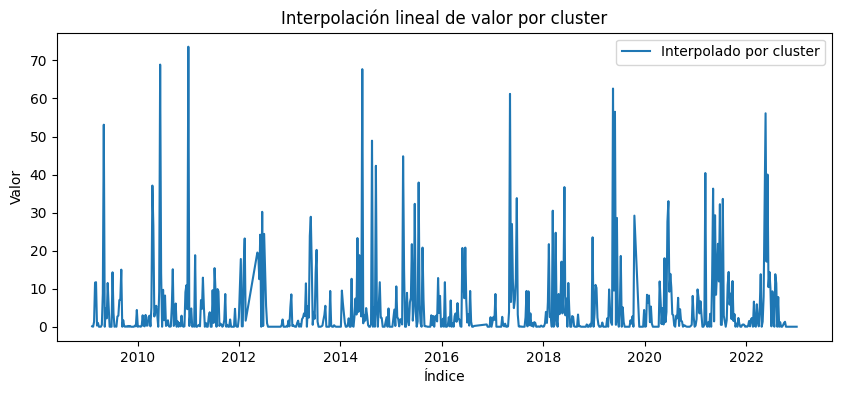

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(dataset_interpolated['value'], label='Interpolado por cluster')
plt.title('Interpolación lineal de valor por cluster')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


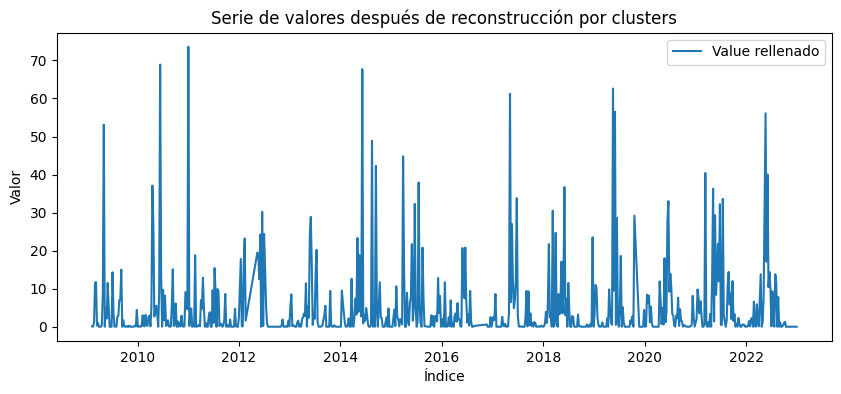

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(dataset_cleaned['value'], label='Value rellenado')
plt.title('Serie de valores después de reconstrucción por clusters')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


In [91]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA

def forecast_series_by_cluster(dataset_resample, start_date, end_date, n_clusters=2, forecast_steps=30):
    # 1. Filtrar el dataset por fechas
    dataset_filtered = dataset_resample.loc[start_date:end_date].copy()
    
    # 2. Eliminar NaN y preparar para clustering
    dataset_cleaned = dataset_filtered.dropna(subset=['value', 'point_6'])
    
    # 3. Aplicar PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(dataset_cleaned[['value', 'point_6']])
    
    # 4. Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    dataset_cleaned['cluster'] = kmeans.fit_predict(pca_data)

    # 5. Asignar clusters al dataset original donde se pueda
    dataset_filtered['cluster'] = None
    valid_mask = dataset_filtered[['value', 'point_6']].notna().all(axis=1)
    dataset_filtered.loc[valid_mask, 'cluster'] = kmeans.predict(dataset_filtered.loc[valid_mask, ['value', 'point_6']])
    
    # 6. Interpolación por cluster
    for clus in dataset_filtered['cluster'].dropna().unique():
        clus_mask = dataset_filtered['cluster'] == clus
        dataset_filtered.loc[clus_mask, 'value'] = dataset_filtered.loc[clus_mask, 'value'].interpolate(method='linear')
    
    # 7. Entrenar modelo de forecasting (usamos cluster 0 como ejemplo)
    cluster_focus = 0
    cluster_data = dataset_filtered[dataset_filtered['cluster'] == cluster_focus]['value'].dropna()

    # Garantizar que es un datetime index
    cluster_data.index = pd.to_datetime(cluster_data.index)

    # 8. Modelo ARIMA simple para forecasting
    model = ARIMA(cluster_data, order=(1, 1, 1))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)
    
    # 9. Generar fechas futuras
    last_date = cluster_data.index[-1]
    future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

    forecast_series = pd.Series(data=forecast, index=future_index, name='forecast_value')
    return forecast_series

forecast = forecast_series_by_cluster(
    dataset_resample=dataset_resample,
    start_date='2022-01-01',
    end_date='2022-12-31',
    n_clusters=2,
    forecast_steps=30
)

print(forecast)


2022-05-23     NaN
2022-05-24     NaN
2022-05-25     NaN
2022-05-26     NaN
2022-05-27     NaN
2022-05-28     NaN
2022-05-29    56.1
2022-05-30     NaN
2022-05-31     NaN
2022-06-01     NaN
2022-06-02     NaN
2022-06-03     NaN
2022-06-04     NaN
2022-06-05    56.1
2022-06-06     NaN
2022-06-07     NaN
2022-06-08     NaN
2022-06-09     NaN
2022-06-10     NaN
2022-06-11     NaN
2022-06-12    56.1
2022-06-13     NaN
2022-06-14     NaN
2022-06-15     NaN
2022-06-16     NaN
2022-06-17     NaN
2022-06-18     NaN
2022-06-19    56.1
2022-06-20     NaN
2022-06-21     NaN
Freq: D, Name: forecast_value, dtype: float64


C:\Users\dreng\AppData\Local\Temp\ipykernel_28340\1851071492.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['cluster'] = kmeans.fit_predict(pca_data)
d:\master BigData\01 proyecto final\codigos\venvbigdata\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
d:\master BigData\01 proyecto final\codigos\venvbigdata\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\master BigData\01 proyecto final\codigos\venvbigdata


## Analisis de la imputacion
---
1. Analisis visual
    - Grafica temporal para ver el estado de las series

In [92]:
from pandas import isnull


print(dataset_resample_filter_level.describe())
print('La cantidad de nulos por columna:\n', dataset_resample_filter_level.isnull().sum())

            value    point_10    point_12     point_6
count  726.000000  724.000000  724.000000  726.000000
mean     4.898347   32.778966   36.093949   37.896910
std      9.712702   34.746298   37.599897   39.698776
min      0.000000    0.000000    0.000000    0.000000
25%      0.000000    4.637538    5.842230    4.457397
50%      0.800000   22.518320   25.519891   26.512882
75%      5.275000   49.407736   53.647509   58.214346
max     73.600000  193.441923  198.799722  198.020075
La cantidad de nulos por columna:
 value       0
point_10    2
point_12    2
point_6     0
dtype: int64


In [93]:
'''import pandas as pd

# Contar los valores nulos por columna
null_counts = dataset.isnull().sum()

# Obtener las filas con valores nulos
null_rows = dataset[dataset.isnull().any(axis=1)]

# Mostrar resultados de forma más clara
print("Cantidad de valores nulos por columna:")
print(null_counts.to_frame(name="Cantidad de nulos"))

print("\nFilas con valores nulos:")
print(null_rows)
'''

'import pandas as pd\n\n# Contar los valores nulos por columna\nnull_counts = dataset.isnull().sum()\n\n# Obtener las filas con valores nulos\nnull_rows = dataset[dataset.isnull().any(axis=1)]\n\n# Mostrar resultados de forma más clara\nprint("Cantidad de valores nulos por columna:")\nprint(null_counts.to_frame(name="Cantidad de nulos"))\n\nprint("\nFilas con valores nulos:")\nprint(null_rows)\n'

In [94]:
'''from sklearn.impute import KNNImputer

# Crear una ventana temporal para KNN (por ejemplo, usar 2 valores anteriores y 2 posteriores)
window_size = 2
dataset['point_6'] = dataset['point_6'].interpolate(method='polynomial', order=3)  # Interpolación inicial para reducir NaNs

# Usar KNNImputer para rellenar los valores faltantes
imputer = KNNImputer(n_neighbors=window_size)  # Usar 2 vecinos
dataset['point_6'] = imputer.fit_transform(dataset[['point_6']])

print('La cantidad de nulos despues de la interpolacion a chirps \n ', dataset.isnull().sum())'''

"from sklearn.impute import KNNImputer\n\n# Crear una ventana temporal para KNN (por ejemplo, usar 2 valores anteriores y 2 posteriores)\nwindow_size = 2\ndataset['point_6'] = dataset['point_6'].interpolate(method='polynomial', order=3)  # Interpolación inicial para reducir NaNs\n\n# Usar KNNImputer para rellenar los valores faltantes\nimputer = KNNImputer(n_neighbors=window_size)  # Usar 2 vecinos\ndataset['point_6'] = imputer.fit_transform(dataset[['point_6']])\n\nprint('La cantidad de nulos despues de la interpolacion a chirps \n ', dataset.isnull().sum())"

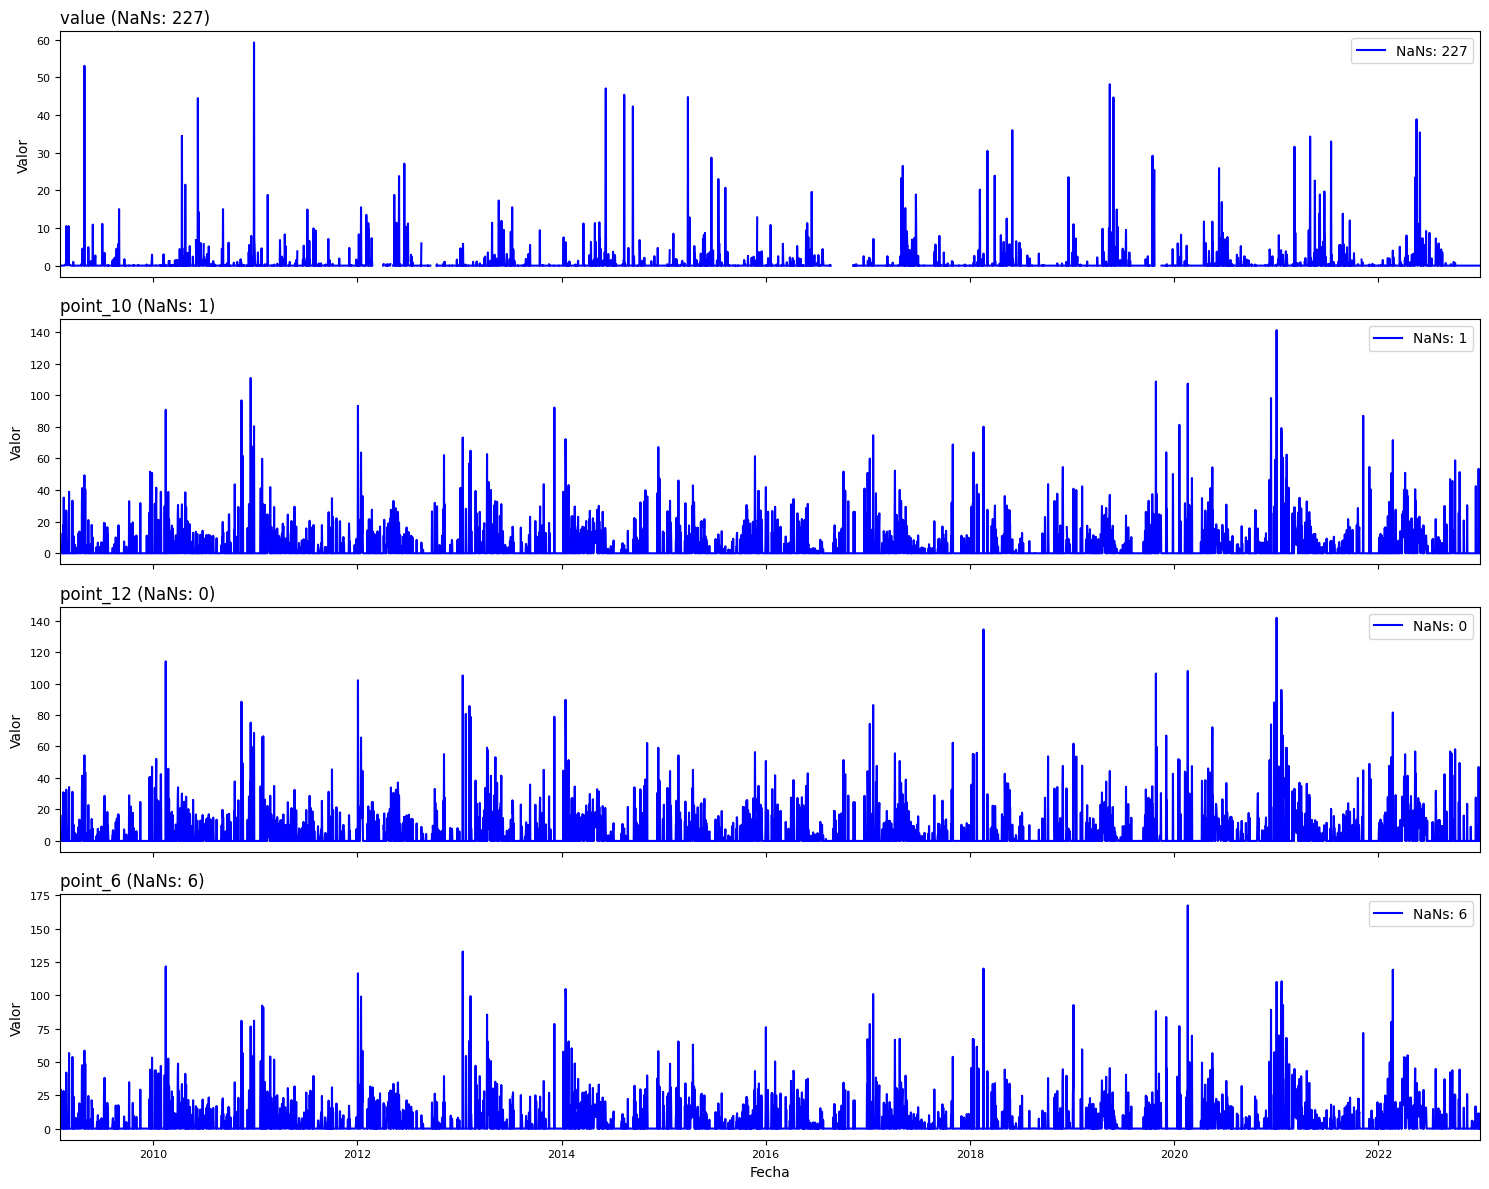

In [95]:
import matplotlib.pyplot as plt

# Crear la figura con subgráficos (uno por cada columna del dataset)
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12), sharex=True)

# Si solo hay una serie, convertir axs en una lista para evitar errores
if dataset.shape[1] == 1:
    axs = [axs]

# Recorrer cada columna del dataset y graficarla
for i, col in enumerate(dataset.columns):
    ax = axs[i]  # Seleccionar el subplot correspondiente
    nan_count = dataset[col].isna().sum()  # Contar los NaNs en la serie
    
    # Graficar la serie con etiqueta de cantidad de NaNs
    ax.plot(dataset.index, dataset[col], color='blue', label=f'NaNs: {nan_count}')
    ax.set_ylabel('Valor', fontsize=10)
    ax.set_title(f"{col} (NaNs: {nan_count})", fontsize=12, loc='left')
    
    # Configuración de ejes
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset.index.min(), dataset.index.max())
    ax.legend(loc='upper right')

# Ajustar espacio entre subgráficos
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()



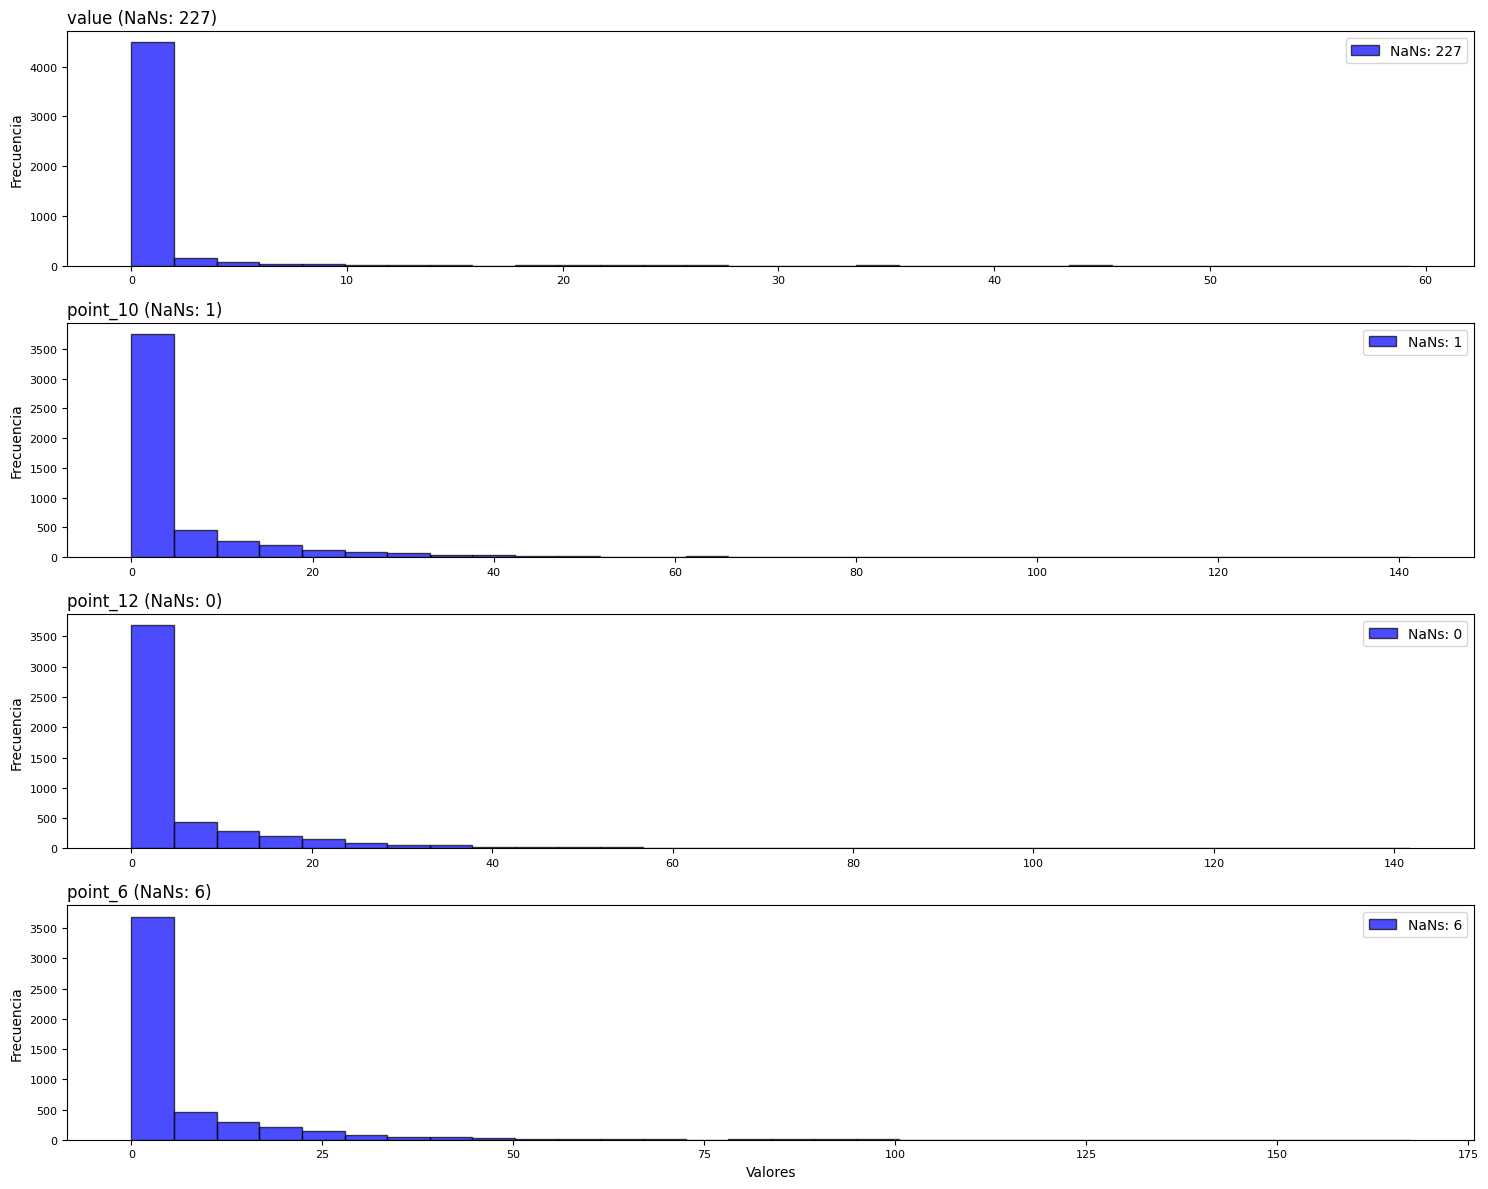

In [96]:
import matplotlib.pyplot as plt

# Crear la figura con subgráficos (uno por cada columna del dataset)
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12), sharex=False)

# Si solo hay una serie, convertir axs en una lista para evitar errores
if dataset.shape[1] == 1:
    axs = [axs]

# Recorrer cada columna del dataset y graficar su histograma
for i, col in enumerate(dataset.columns):
    ax = axs[i]  # Seleccionar el subplot correspondiente
    nan_count = dataset[col].isna().sum()  # Contar los NaNs en la serie
    
    # Graficar el histograma con etiqueta de cantidad de NaNs
    ax.hist(dataset[col].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black', label=f'NaNs: {nan_count}')
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.set_title(f"{col} (NaNs: {nan_count})", fontsize=12, loc='left')
    
    # Configuración de ejes
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(loc='upper right')

# Ajustar espacio entre subgráficos
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Valores")
plt.tight_layout()
plt.show()


En estas se ve que la serie de tumaco es la que presenta mas numero de ausentes, estos son lo objetivos a rellenar, en las otras tambien se precentan ausentes, unas de las posibles causas es el umbral de filtrado anteriormente aplicado o la ausencia del dato dentro de la base de datos.

- Ajuste de dataset

    En este paso se **eliminan** las filas con **NaN** contenidas en el data set, y se almacenan en otra variable.

In [97]:
# Crear un dataframe con solo las filas con datos en todas las columnas
dataset_no_nan = dataset.dropna()
display(dataset_no_nan.isna().sum())
dataset_no_nan.shape

value       0
point_10    0
point_12    0
point_6     0
dtype: int64

(4848, 4)

- filtrado de extremos
    se evalua opcionalmente el eliminar los extremos de la serie de la red mpomm para mejorar la correlacion

In [98]:
dataset_no_nan = dataset_no_nan[dataset_no_nan['tumaco']<=200]

KeyError: 'tumaco'

- Remuestreo del dataset

    Se aplica la funcion de remuestreco dejando pasar los datos que tengan el **20%** de **NaN* como maximo umbral permitido.

- Graficas

    Se crea un grafico de correlaciones las cuales permiten visualizar la distribucion de la correlacion cruzada de las series ente series, tambien una tabla con la estimacion numerica de las correlaciones

In [ ]:
#dataset_no_nan=dataset_no_nan.iloc[:,-4:]
import seaborn as sns
sns.pairplot(dataset_no_nan)
round(dataset_no_nan.describe(),3)

- Mapa de calor

    Se crea un mapa de calor de las correlaciones para poder visualizar de manera adecuada y analizar las series.

In [ ]:
# Crear el heatmap de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(dataset_no_nan.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Analisis de Correlación de las series")
plt.show()

En esta nos debemos centrar en la fila y columna de tumaco ya que es la que debemos predecir para recuperar los datos, entonces podemos analizar que se correlacionan al rededor del *60%* de las demas series. es pertinente continual con el analisis exploratorio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Supongamos que dataset_no_nan es tu DataFrame sin valores nulos
# Asegúrate de que las columnas 2 y 1 sean las correctas para X e y
X = dataset_no_nan.iloc[:, 2].values.reshape(-1, 1)  # Variable predictora (columna 2)
y = dataset_no_nan.iloc[:, 0].values  # Variable respuesta (columna 1)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X, y)

# Predecir valores para la línea de regresión
y_pred = modelo.predict(X)

# Gráfico de dispersión con línea de regresión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.flatten(), y=y, color='blue', label='Datos reales')
sns.lineplot(x=X.flatten(), y=y_pred, color='red', label='Línea de regresión')
plt.title('Regresión Lineal')
plt.xlabel('Variable Predictora (X)')
plt.ylabel('Variable Respuesta (y)')
plt.legend()
plt.show()

# Mostrar ecuación de la recta
print(f"Ecuación de la recta: y = {round(float(modelo.coef_[0]), 2)}x + {round(float(modelo.intercept_), 2)}")

# Coeficiente de correlación
corr = np.corrcoef(X.flatten(), y)[0, 1]
print(f"Coeficiente de correlación: {round(corr, 2)}")

# Coeficiente de determinación (R^2)
r2 = r2_score(y, y_pred)
print(f"Coeficiente de determinación (R²): {round(r2, 2)}")

- Modelo

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Datos y variables
xTrain = dataset_no_nan.iloc[:, 1:]  # Variables predictoras
yTrain = dataset_no_nan.iloc[:, 0]   # Variable a predecir

# Escalar los datos de entrenamiento
scaler = StandardScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)

# Crear el modelo con los mejores hiperparámetros
regr = MLPRegressor(
    random_state=1, 
    max_iter=5000, 
    activation='tanh', 
    alpha=0.001, 
    hidden_layer_sizes=(75,150), 
    learning_rate='constant'
)

# Entrenar el modelo
regr.fit(xTrainScaled, yTrain)
# Datos de prueba
xTest = dataset.iloc[:, 1:].dropna()  # Eliminar filas con NaN
yTest = dataset.iloc[:, 0].dropna()   # Asegúrate de que yTest esté alineado con xTest

# Escalar los datos de prueba
xTestScaled = scaler.transform(xTest.values)

# Realizar la predicción en los datos de prueba
yPredict = regr.predict(xTestScaled)

# Comparación con estación 2
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dataset.index, dataset.iloc[:, 0], label=dataset.columns[0], color='blue')  # Datos reales
ax.plot(xTest.index, yPredict, label='Predicción', color='red')  # Predicciones

# Agregar leyenda, títulos y cuadrícula
plt.legend()
plt.title("Comparación de la estación 2 - Predicción vs Real")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
'''from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

from itertools import product

# Generar combinaciones de tamaños de capas de 50 a 150
def generate_layer_combinations():
    layer_sizes = [50, 100, 150]
    combinations = []
    for i in range(1, 4):  # Hasta 3 capas
        combinations.extend(product(layer_sizes, repeat=i))
    return combinations

param_space = {
    'hidden_layer_sizes': generate_layer_combinations(),
    'alpha': (1e-5, 1e-1, 'log-uniform'),
    'learning_rate': ['constant', 'adaptive'],
    'activation': ['relu', 'tanh', 'logistic'],
}


# Crear el modelo base
mlp = MLPRegressor(random_state=1, max_iter=5000)

# Búsqueda Bayesiana
bayes_search = BayesSearchCV(
    estimator=mlp,
    search_spaces=param_space,
    n_iter=30,  # Iteraciones de búsqueda
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='r2',  # Métrica R²
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo
bayes_search.fit(xTrainScaled, yTrain)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(bayes_search.best_params_)

# Entrenar el modelo final con los mejores hiperparámetros
best_model = bayes_search.best_estimator_

# Realizar la predicción
yPredict = best_model.predict(xTestScaled)


# Gráfico de comparación
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dataset.index, dataset.iloc[:, 0], label=dataset.columns[0], color='blue')  # Datos reales
ax.plot(xTest.index, yPredict, label='Predicción', color='red')  # Predicciones

# Agregar leyenda y cuadrícula
plt.legend()
plt.title("Comparación de la estación 2 - Predicción vs Real")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
'''

- busqueda de lso mejores hiperparametros

    en esta rutina se automatiza la busqueda de los mejores parametros dependiendo de un subconjunto de combianciones dadas. esta es una rutina intensiva que ruequiere uchos reursod de hardware.

In [ ]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Conjunto de hiperparámetros para buscar
param_grid = {
    'hidden_layer_sizes': [(50, 50), (50, 100),(75,150), (100, 100), (150, 100, 50)],  # Varias combinaciones de capas
    'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'learning_rate': ['identity','constant', 'adaptive', 'invscaling'],  # Estrategia de ajuste de la tasa de aprendizaje
    'activation': ['relu', 'tanh', 'logistic'],  # Funciones de activación
}

# Crear el modelo base
mlp = MLPRegressor(random_state=1, max_iter=5000)

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(xTrainScaled, yTrain)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Entrenar el modelo final con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Realizar la predicción en los datos de prueba
yPredict = best_model.predict(xTestScaled)


# Gráfico de comparación con estación 2
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dataset.index, dataset.iloc[:, 0], label=dataset.columns[0], color='blue')  # Datos reales
ax.plot(xTest.index, yPredict, label='Predicción', color='red')  # Predicciones

# Agregar leyenda, títulos y cuadrícula
plt.legend()
plt.title("Comparación de la estación 2 - Predicción vs Real")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()'''

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(regr, xTrainScaled, yTrain, cv=10, n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score')
plt.title('Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend()
plt.show()


- Relleno de datos

In [ ]:
# Se crea una nueva columna para agregar los datos
dataset[dataset.columns[0]+"_imputada"] = 0 #ajustar
# Agregar los datos en la matriz (se agregan solamente predicciones donde no hay datos observados)

for index, row in dataset.iterrows():
    if np.isnan(row[dataset.columns[0]]) and ~np.isnan(row[dataset.columns[1]]) and ~np.isnan(row[dataset.columns[2]]):
        row_input = np.array([[np.nan, row[dataset.columns[1]], row[dataset.columns[2]]]])

        # Asegurar que el número de características coincida con scaler
        rowScaled = scaler.transform(np.nan_to_num(row_input)) 

        # Realizar la predicción y convertir el resultado a float explícitamente
        predicted_value = float(regr.predict(rowScaled)[0])  

        # Asignar el valor asegurando que el tipo de dato es compatible
        dataset.loc[index, dataset.columns[0] + "_imputada"] = predicted_value

    elif ~np.isnan(row[dataset.columns[0]]): #ajustar
        dataset.loc[index,[dataset.columns[0]+"_imputada"]] = row[dataset.columns[0]] #ajustar 
    else:
        row[dataset.columns[0]+"_imputada"] = np.nan #ajustar


### Graficar los resultados de la imputacion

    Aqui podemos comparar de manera interactiva como se  comportan las 3 series de analisis, la real, las prediciones y la serie imputada.  

In [ ]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Añadir la serie de datos original (ajuste)
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:, 0], mode='lines', name=dataset.columns[0]))

# Añadir la predicción
fig.add_trace(go.Scatter(x=xTest.index, y=yPredict, mode='lines', name='Predicción'))

#Añadir imputada
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:,-1], mode='lines', name=dataset.columns[-1] ))

# Añadir leyenda
fig.update_layout(
    title="Comparison of Station 2",
    xaxis_title="Timestamp",
    yaxis_title="Value",
    xaxis_tickangle=-90,
    legend_title="Legend",
    template="plotly",
)
print(dataset.iloc[:, 0].corr(dataset.iloc[:,-1]))
# Mostrar la figura
fig.show()


In [ ]:
dataset_complet = dataset.copy()
dataset_complet.drop(columns=['tumaco'])
# Crear el heatmap de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(dataset_complet.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Analisis de Correlación de las series completas")
plt.show()

## **Imputaicon de datos**
---
- Visualizar el estado inicial del *dataset* en cuestrion de valores nulos  y Nan para tener idea de los rellenos 

In [ ]:
import matplotlib.pyplot as plt

#dataset_no_nan es un DataFrame con varias columnas
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Usando zip para iterar a través de las columnas y sus títulos
for ax, data, title in zip(axes, dataset_no_nan.values.T, dataset_no_nan.columns):
    ax.plot(data, linestyle='-', label=title)
    ax.set_ylabel("Valor Sensor")
    ax.legend()
    ax.grid(True)

# Configurar el título general
plt.suptitle("Series de Tiempo con Diferentes Agregaciones", fontsize=14)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


Como vemos en este caso tenemos distintos esenarios dependiendo del año, podemos analizar que existen sereis que tienen baches pequeños y otras que tienen grandes periodos de ausencias de datos.
En las siguientes etapas trataremos cada año de manera individual para realizar el reyeno de los datos, comenzamos con el reyeno de las series que tienen menos cantidad de datos faltantes.

## Analisis de la imputacion de series temporales
---

Comenzamos con la inspeccion visual detallada de la serie, para este caso particular comenzamos con la serie de 2009.

1. Grafica temporal


In [ ]:
# Filtrar datos del año 2009
year = 2009
data = serie[serie.index.year == year]

# Crear la figura
plt.figure(figsize=(8, 5))
plt.plot(data.index, data.values, label=f'Serie {year}', linewidth=2, color="b")

# Etiquetas y título
plt.xlabel(params['variable_name'])
plt.ylabel("Valor")
plt.title(f'Gráfico temporal de la serie de tiempo de {year}, (NaN: {data.isna().sum()})')
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()


# Analisis estadistico


- Analisis descriptivo

Para esto realizamos una serie de graficas temporales para distintos instantes de remuestreo con el fin de obtener patrones y tendencias en el tiempo.

### Grafico temporal
En estos graficos se pretende comprender la naturaleza de los datos es decir como es el comportamiento a lo largo del tiempo, asi mismo se estima visualmente cuantos baches y de que tamaño se tienen en la serie

Para la series remuestreadas se utilizan criterios variables, es decir, si el 20% de los datos de la semana son nulos entonces el acumulado semanal correspondiente tambien sera nulo. asi tenemos un criterio de calidad para poder determinar con cuantos datos de la serie trabajamos.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Resampleo con diferentes períodos de agregación
daily_serie = dataset.iloc[:,-1].resample('D').apply(lambda g: custom_resample(g, nan_threshold=0.2))
weekly_serie = dataset.iloc[:,-1].resample('W').apply(lambda g: custom_resample(g, nan_threshold=0.2))
monthly_serie = dataset.iloc[:,-1].resample('ME').apply(lambda g: custom_resample(g, nan_threshold=0.2))
quarterly_serie = dataset.iloc[:,-1].resample('3ME').apply(lambda g: custom_resample(g, nan_threshold=0.2))
display(dataset.iloc[:,-1].head(2))
# Crear figura con subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Definir títulos y datos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

for ax, data, title in zip(axes, series, titles):
    ax.plot(data, marker='o', linestyle='-', label=title)
    ax.set_ylabel("Valor Sensor")
    ax.legend()
    ax.grid(True)

# Configurar el título general
plt.suptitle("Series de Tiempo con Diferentes Agregaciones", fontsize=14)
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


### Grafico de dstribucion de los datos
En estos graficos se presentan las distribuciones de cada serie, con esto se pretende tener una vision estadistica de la centralizacion de las series.

In [ ]:
import matplotlib.pyplot as plt

# Crear figura con subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))  # No compartimos ejes

# Definir datos, títulos y colores
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Histograma Diario", "Histograma Semanal", "Histograma Mensual", "Histograma Trimestral"]
colors = ['royalblue', 'seagreen', 'tomato', 'purple']  # Colores diferenciados

for ax, data, title, color in zip(axes, series, titles, colors):
    ax.hist(data.dropna(), bins='auto', alpha=0.7, edgecolor='black', color=color, density=True)
    ax.set_ylabel("Densidad")
    ax.set_title(title)
    ax.grid(True)

# Configurar título general
plt.suptitle("Distribución de Valores de las Series de Tiempo", fontsize=14)
plt.xlabel("Valor Sensor")
plt.tight_layout()
plt.show()


## Analisis de auto correlacion
Este analisis se utiliza para determinar si una serie es estacional y ademas ayuda a determinar los coeficientes del modelo arima y sarima

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Crear figura con subplots para PACF
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# Definir títulos y datos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

for i, (data, title) in enumerate(zip(series, titles)):
    lags = min(100, len(data.dropna()) // 2)  # Ajuste dinámico de rezagos
    if lags > 0:
        plot_acf(data.dropna(), ax=axes[i, 0], lags=lags)
        plot_pacf(data.dropna(), ax=axes[i, 1], method='ywm', lags=lags)
    axes[i, 0].set_title(f"ACF - {title}")
    axes[i, 1].set_title(f"PACF - {title}")

fig.savefig("acf_pacf_figure.svg", format="svg")
plt.tight_layout()
plt.show()


- En esta grafica podremos interactuar con cualquiera de las anteriores, se realiza este paso para poder analizar a detalle cada serie, en el proceso exploratorio.

### Analisis de estacionaridad
---
Una serie es estacionaria si su media y varianza son constantes en el tiempo y no muestra una tendencia creciente o decreciente.
A continuacion se despliegan una serie de pruebas para determinar si la serie es estacionaria.

**✅ Pruebas estadísticas para Estacionariedad**
1. Prueba de Dickey-Fuller Aumentada (ADF)

**Objetivo:** Determinar si la serie tiene una raíz unitaria (lo que indica no estacionariedad).

- Hipótesis Nula (H₀): La serie tiene una raíz unitaria (NO es estacionaria).
- Hipótesis Alternativa (H₁): La serie es estacionaria.
- Si p-valor < 0.05, rechazamos H₀ → La serie es estacionaria.

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# Definir series y títulos
series = [daily_serie, weekly_serie, monthly_serie, quarterly_serie]
titles = ["Serie Diaria", "Serie Semanal", "Serie Mensual", "Serie Trimestral"]

fig = go.Figure()

for i, (data, title) in enumerate(zip(series, titles)):
    data_clean = data.dropna()
    lags = min(100, len(data_clean) // 2)  # Ajuste dinámico de rezagos
    if lags > 0:
        acf_values = acf(data_clean, nlags=lags)
        pacf_values = pacf(data_clean, nlags=lags, method='ywm')
        
        fig.add_trace(go.Bar(x=list(range(lags+1)), y=acf_values, name=f"ACF - {title}"))
        fig.add_trace(go.Bar(x=list(range(lags+1)), y=pacf_values, name=f"PACF - {title}"))

fig.update_layout(title="ACF y PACF de las Series de Tiempo", xaxis_title="Rezagos", yaxis_title="Valor", barmode='group')
fig.show()


2. Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

**Objetivo:** Detectar si la serie es estacionaria en nivel o tendencia.

- Hipótesis Nula (H₀): La serie es estacionaria.
- Hipótesis Alternativa (H₁): La serie NO es estacionaria.
- Si p-valor < 0.05, rechazamos H₀ → La serie NO es estacionaria.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(serie, name="Serie"):
    serie = serie.dropna()  # Eliminar NaN
    if len(serie) < 10:  # Mínimo requerido para ADF
        print(f"⚠️ {name}: La serie es muy corta para ADF.")
        return
    
    result = adfuller(serie)
    
    print(f"\n🔍 **Prueba ADF para {name}**")
    print("Estadístico de Prueba ADF:", result[0])
    print("P-valor:", result[1])
    print("Valores Críticos:", result[4])
    
    if result[1] < 0.05:
        print("✅ La serie es estacionaria")
    else:
        print("❌ La serie NO es estacionaria (podría requerir diferenciación)")
        
        # Aplicar diferenciación
        diff_serie = serie.diff().dropna()
        result_diff = adfuller(diff_serie)
        
        print("\n📉 **Prueba ADF tras una diferenciación**")
        print("Estadístico de Prueba ADF:", result_diff[0])
        print("P-valor:", result_diff[1])
        if result_diff[1] < 0.05:
            print("✅ Tras una diferenciación, la serie es estacionaria")
        else:
            print("❌ La serie sigue sin ser estacionaria, podría requerir una segunda diferenciación")

# Aplicar prueba ADF a múltiples series
for i, serie in enumerate(series):
    test_stationarity(serie, name=f"Serie {i+1}")


In [ ]:
from statsmodels.tsa.stattools import kpss

def test_kpss(serie, name="Serie"):
    serie = serie.dropna()  # Eliminar NaN
    if len(serie) < 10:  # Mínimo requerido para KPSS
        print(f"⚠️ {name}: La serie es muy corta para KPSS.")
        return
    
    result = kpss(serie, regression='c', nlags="auto")  # 'c' = tendencia constante
    
    print(f"\n🔍 **Prueba KPSS para {name}**")
    print("Estadístico de Prueba KPSS:", result[0])
    print("P-valor:", result[1])
    print("Valores Críticos:", result[3])
    
    if result[1] < 0.05:
        print("❌ La serie NO es estacionaria según KPSS (tiene tendencia)")
    else:
        print("✅ La serie es estacionaria según KPSS")

# Aplicar prueba KPSS a múltiples series
for i, serie in enumerate(series):
    test_kpss(serie, name=f"Serie {i+1}")


### Analisis de Estacionalidad
---
La estacionalidad ocurre cuando hay patrones repetitivos en intervalos regulares.

**✅ Pruebas estadísticas para Estacionalidad**

1. Prueba de Friedman

Evalúa si los valores de la serie cambian sistemáticamente a lo largo del tiempo.


In [ ]:
from scipy.stats import friedmanchisquare
import numpy as np

def test_friedman(serie):
    n_periodos = 12  # Por ejemplo, mensual
    grupos = [serie[i::n_periodos] for i in range(n_periodos)]
    stat, p = friedmanchisquare(*grupos)
    print("Estadístico de Prueba Friedman:", stat)
    print("P-valor:", p)

    if p < 0.05:
        print("✅ La serie tiene estacionalidad")
    else:
        print("❌ No hay evidencia de estacionalidad")

for serie in dataset_complet:
    test_friedman(serie)


2. Prueba de Kruskal-Wallis

prueba no paramétrica que evalúa diferencias entre períodos.

In [ ]:
from scipy.stats import kruskal

def test_kruskal(serie):
    n_periodos = 12
    grupos = [serie.iloc[:,-1][i::n_periodos] for i in range(n_periodos)]
    stat, p = kruskal(*grupos)
    print("Estadístico de Prueba Kruskal-Wallis:", stat)
    print("P-valor:", p)

    if p < 0.05:
        print("✅ La serie tiene estacionalidad")
    else:
        print("❌ No hay evidencia de estacionalidad")

for serie in dataset_complet:
    test_kruskal(serie)


### Visualización de Estacionariedad y Estacionalidad
---
✅ Gráfico de Tendencia y Estacionalidad con STL

El método STL (Seasonal-Trend Decomposition) descompone la serie en:

1. Tendencia
2. Estacionalidad
3. Residuo (ruido aleatorio)

In [ ]:
from statistics_utils.eda.timeseries import decompose_time_series

descompose=decompose_time_series(dataset.iloc[:,-1])
descompose

| Tipo             | Pruebas                | Conclusión                                              |
|-----------------|------------------------|---------------------------------------------------------|
| Estacionariedad | ADF, KPSS               | Si no es estacionaria, aplicar diferenciación (d) en ARIMA |
| Estacionalidad  | Friedman, Kruskal-Wallis, STL | Si hay estacionalidad, usar SARIMA en vez de ARIMA     |



En este analisis crearemos una rutina para la descripcion, descomposicion y analisiz a profundidad de las series de tiempo de la red mpomm alojadas en la base de datos oficial.

## Analisis estadistico

- Analisis descriptivo